In [1]:
'''
!pip install Cython
!git clone https://github.com/waleedka/coco.git

!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI
'''

'\n!pip install Cython\n!git clone https://github.com/waleedka/coco.git\n\n!pip install -U setuptools\n!pip install -U wheel\n!make install -C coco/PythonAPI\n'

In [2]:
import os
import sys
import random
import math
import numpy as np
import csv
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import imageio
import datetime
import tensorflow as tf
import keras
from keras.callbacks import LearningRateScheduler



# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Ignore Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
print(ROOT_DIR)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/interior/"))  # To find local version
sys.path.append('')  # To find local version
import projection1
import interior_seq

%matplotlib inline 
%load_ext tensorboard

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
print('finished')

/home/erbachj/MaskRCNN/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/erbachj/MaskRCNN/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/erbachj/MaskRCNN/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/erbachj/MaskRCNN/local/lib/python3.6/site-packages/tensorf

/media/scratch1/erbachj/MaskRCNN/Mask_RCNN


finished


In [3]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


In [4]:
class_names = ['BG', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa',
               'table', 'door', 'window', 'bookshelf', 'picture', 'counter',
               'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 
               'mirror', 'floor', 'clothes', 'ceiling', 'books', 'refridgerator',
               'television', 'paper', 'towel', 'shower', 'box', 'whiteboard', 
               'person', 'night', 'toilet', 'sink', 'lamp', 'bathtub', 'bag', 
               'otherstructure', 'otherfurniture', 'otherprop']

selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'window', 
                    'picture', 'blinds', 'shelves', 'curtain', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
# without curtain
selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'window', 
                    'picture', 'blinds', 'shelves', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
print(class_names[15])

shelves


In [5]:
NYU40_to_sel_map = {}
selected_class_list = []

for i in range(len(class_names)):
    if class_names[i] in selected_classes:
        NYU40_to_sel_map[i] = selected_classes.index(class_names[i])
        selected_class_list.append(i)
    else:
        NYU40_to_sel_map[i] = 0
NYU40_to_sel_map[class_names.index('desk')] = selected_classes.index('table')
NYU40_to_sel_map[class_names.index('bookshelf')] = selected_classes.index('shelves')
NYU40_to_sel_map[class_names.index('refridgerator')] = selected_classes.index('refrigerator')
selected_class_list.append(class_names.index('desk'))
selected_class_list.append(class_names.index('bookshelf'))
selected_class_list.append(class_names.index('refridgerator'))

"""
NYU40_to_sel_map = {'BG': 'BG', 'wall': 'BG', 'floor': 'BG', 'cabinet': 'cabinet', 
                    'bed': 'bed', 'chair': 'chair', 'sofa': 'sofa', 'table': 'table', 
                    'door': 'BG', 'window': 'window', 'bookshelf': 'shelves', 
                    'picture': 'picture', 'counter': 'BG', 'blinds': 'blinds', 
                    'desk': 'table', 'shelves': 'shelves', 'curtain': 'curtain', 
                    'dresser': 'dresser', 'pillow': 'pillow', 'mirror': 'mirror', 
                    'clothes': 'clothes', 'ceiling': 'BG', 'books': 'books', 
                    'refridgerator': 'refrigerator', 'television': 'television', 
                    'paper': 'paper', 'towel': 'towel', 'shower': 'BG', 'box': 'BG', 
                    'whiteboard': 'BG', 'person': 'BG', 'night': 'BG', 'toilet': 'toilet',
                    'sink': 'sink', 'lamp': 'lamp', 'bathtub': 'bathtub', 'bag': 'bag', 
                    'otherstructure': 'BG', 'otherfurniture': 'BG', 'otherprop': 'BG'}
"""

print(NYU40_to_sel_map)
print(selected_class_list)

{0: 0, 1: 0, 2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 0, 9: 6, 10: 9, 11: 7, 12: 0, 13: 8, 14: 5, 15: 9, 16: 0, 17: 10, 18: 11, 19: 12, 20: 0, 21: 13, 22: 0, 23: 14, 24: 15, 25: 16, 26: 17, 27: 18, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 19, 34: 20, 35: 21, 36: 22, 37: 23, 38: 0, 39: 0, 40: 0}
[0, 3, 4, 5, 6, 7, 9, 11, 13, 15, 17, 18, 19, 21, 23, 25, 26, 27, 33, 34, 35, 36, 37, 14, 10, 24]


In [6]:
#TRAIN_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDDWIQX7_Dining_room'
#TRAIN_DIR = os.path.join(TRAIN_DIR,'cam0/data/')
TRAIN_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')
print(TRAIN_DIR)
# Training dataset
dataset_train = interior_seq.InteriorDataset()
dataset_train.load_Interior(dataset_dir=TRAIN_DIR, subset='train', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_train.prepare()

# Validation dataset
#VAL_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDEI1LAV_Dining_room'
#VAL_DIR = os.path.join(VAL_DIR,'cam0/data/')
VAL_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')

dataset_val = interior_seq.InteriorDataset()
dataset_val.load_Interior(dataset_dir=VAL_DIR, subset='val', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_val.prepare()

/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7
HD7
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGLXTKQ9_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGLXTKQ9_Bedroom_id0
3FO4MGLXTKQ9_Bedroom_id1
3FO4MGLXTKQ9_Bedroom_id2
3FO4MGLXTKQ9_Bedroom_id3
3FO4MGLXTKQ9_Bedroom_id4
3FO4MGLXTKQ9_Bedroom_id5
3FO4MGLXTKQ9_Bedroom_id6
3FO4MGLXTKQ9_Bedroom_id7
3FO4MGLXTKQ9_Bedroom_id8
3FO4MGLXTKQ9_Bedroom_id9
3FO4MGLXTKQ9_Bedroom_id10
3FO4MGLXTKQ9_Bedroom_id11
3FO4MGLXTKQ9_Bedroom_id12
3FO4MGLXTKQ9_Bedroom_id13
3FO4MGLXTKQ9_Bedroom_id14
3FO4MGLXTKQ9_Bedroom_id15
3FO4MGLXTKQ9_Bedroom_id16
3FO4MGLXTKQ9_Bedroom_id17
3FO4MGLXTKQ9_Bedroom_id18
3FO4MGLXTKQ9_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKMSP2YT_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKMSP2YT_Bedroom_id0
3FO4MKMSP2YT_Bedroom_id1
3FO4MKMSP

Done (t=0.00s)
creating index...
index created!
3FO4MFPNIEPY_Dining_room_id0
3FO4MFPNIEPY_Dining_room_id1
3FO4MFPNIEPY_Dining_room_id2
3FO4MFPNIEPY_Dining_room_id3
3FO4MFPNIEPY_Dining_room_id4
3FO4MFPNIEPY_Dining_room_id5
3FO4MFPNIEPY_Dining_room_id6
3FO4MFPNIEPY_Dining_room_id7
3FO4MFPNIEPY_Dining_room_id8
3FO4MFPNIEPY_Dining_room_id9
3FO4MFPNIEPY_Dining_room_id10
3FO4MFPNIEPY_Dining_room_id11
3FO4MFPNIEPY_Dining_room_id12
3FO4MFPNIEPY_Dining_room_id13
3FO4MFPNIEPY_Dining_room_id14
3FO4MFPNIEPY_Dining_room_id15
3FO4MFPNIEPY_Dining_room_id16
3FO4MFPNIEPY_Dining_room_id17
3FO4MFPNIEPY_Dining_room_id18
3FO4MFPNIEPY_Dining_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKOU5GXM_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKOU5GXM_Bedroom_id0
3FO4MKOU5GXM_Bedroom_id1
3FO4MKOU5GXM_Bedroom_id2
3FO4MKOU5GXM_Bedroom_id3
3FO4MKOU5GXM_Bedroom_id4
3FO4MKOU5GXM_Bedroom_id5
3FO4MKOU5GXM_Bedroom_id6
3FO4MKOU

3FO4MKOUMXTU_Bedroom_id6
3FO4MKOUMXTU_Bedroom_id7
3FO4MKOUMXTU_Bedroom_id8
3FO4MKOUMXTU_Bedroom_id9
3FO4MKOUMXTU_Bedroom_id10
3FO4MKOUMXTU_Bedroom_id11
3FO4MKOUMXTU_Bedroom_id12
3FO4MKOUMXTU_Bedroom_id13
3FO4MKOUMXTU_Bedroom_id14
3FO4MKOUMXTU_Bedroom_id15
3FO4MKOUMXTU_Bedroom_id16
3FO4MKOUMXTU_Bedroom_id17
3FO4MKOUMXTU_Bedroom_id18
3FO4MKOUMXTU_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4ML24EQFY_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4ML24EQFY_Bedroom_id0
3FO4ML24EQFY_Bedroom_id1
3FO4ML24EQFY_Bedroom_id2
3FO4ML24EQFY_Bedroom_id3
3FO4ML24EQFY_Bedroom_id4
3FO4ML24EQFY_Bedroom_id5
3FO4ML24EQFY_Bedroom_id6
3FO4ML24EQFY_Bedroom_id7
3FO4ML24EQFY_Bedroom_id8
3FO4ML24EQFY_Bedroom_id9
3FO4ML24EQFY_Bedroom_id10
3FO4ML24EQFY_Bedroom_id11
3FO4ML24EQFY_Bedroom_id12
3FO4ML24EQFY_Bedroom_id13
3FO4ML24EQFY_Bedroom_id14
3FO4ML24EQFY_Bedroom_id15
3FO4ML24EQFY_Bedroom_id16
3FO4ML24EQFY_Bedroom_id17
3FO

3FO4MFDMGVDO_Bedroom_id8
3FO4MFDMGVDO_Bedroom_id10
3FO4MFDMGVDO_Bedroom_id11
3FO4MFDMGVDO_Bedroom_id12
3FO4MFDMGVDO_Bedroom_id13
3FO4MFDMGVDO_Bedroom_id14
3FO4MFDMGVDO_Bedroom_id16
3FO4MFDMGVDO_Bedroom_id17
3FO4MFDMGVDO_Bedroom_id18
3FO4MFDMGVDO_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIW0ABNI_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIW0ABNI_Bedroom_id0
3FO4MIW0ABNI_Bedroom_id1
3FO4MIW0ABNI_Bedroom_id2
3FO4MIW0ABNI_Bedroom_id3
3FO4MIW0ABNI_Bedroom_id4
3FO4MIW0ABNI_Bedroom_id6
3FO4MIW0ABNI_Bedroom_id7
3FO4MIW0ABNI_Bedroom_id8
3FO4MIW0ABNI_Bedroom_id9
3FO4MIW0ABNI_Bedroom_id10
3FO4MIW0ABNI_Bedroom_id11
3FO4MIW0ABNI_Bedroom_id12
3FO4MIW0ABNI_Bedroom_id13
3FO4MIW0ABNI_Bedroom_id14
3FO4MIW0ABNI_Bedroom_id15
3FO4MIW0ABNI_Bedroom_id16
3FO4MIW0ABNI_Bedroom_id17
3FO4MIW0ABNI_Bedroom_id18
3FO4MIW0ABNI_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3F

3FO4MLNL40PC_Bedroom_id18
3FO4MLNL40PC_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIVYKUO7_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIVYKUO7_Bedroom_id0
3FO4MIVYKUO7_Bedroom_id1
3FO4MIVYKUO7_Bedroom_id3
3FO4MIVYKUO7_Bedroom_id5
3FO4MIVYKUO7_Bedroom_id6
3FO4MIVYKUO7_Bedroom_id7
3FO4MIVYKUO7_Bedroom_id8
3FO4MIVYKUO7_Bedroom_id9
3FO4MIVYKUO7_Bedroom_id10
3FO4MIVYKUO7_Bedroom_id11
3FO4MIVYKUO7_Bedroom_id12
3FO4MIVYKUO7_Bedroom_id13
3FO4MIVYKUO7_Bedroom_id14
3FO4MIVYKUO7_Bedroom_id15
3FO4MIVYKUO7_Bedroom_id16
3FO4MIVYKUO7_Bedroom_id17
3FO4MIVYKUO7_Bedroom_id18
3FO4MIVYKUO7_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKS6T8XY_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKS6T8XY_Bedroom_id0
3FO4MKS6T8XY_Bedroom_id1
3FO4MKS6T8XY_Bedroom_id2
3FO4MKS6T8XY_Bedroom_id3
3FO4MKS6T8XY_Bedroom_id4
3FO4M

3FO4MKUV144Y_Living_room_id12
3FO4MKUV144Y_Living_room_id13
3FO4MKUV144Y_Living_room_id14
3FO4MKUV144Y_Living_room_id15
3FO4MKUV144Y_Living_room_id16
3FO4MKUV144Y_Living_room_id17
3FO4MKUV144Y_Living_room_id18
3FO4MKUV144Y_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MEV76WSI_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MEV76WSI_Dining_room_id0
3FO4MEV76WSI_Dining_room_id1
3FO4MEV76WSI_Dining_room_id2
3FO4MEV76WSI_Dining_room_id3
3FO4MEV76WSI_Dining_room_id4
3FO4MEV76WSI_Dining_room_id5
3FO4MEV76WSI_Dining_room_id6
3FO4MEV76WSI_Dining_room_id7
3FO4MEV76WSI_Dining_room_id8
3FO4MEV76WSI_Dining_room_id9
3FO4MEV76WSI_Dining_room_id10
3FO4MEV76WSI_Dining_room_id11
3FO4MEV76WSI_Dining_room_id12
3FO4MEV76WSI_Dining_room_id13
3FO4MEV76WSI_Dining_room_id14
3FO4MEV76WSI_Dining_room_id15
3FO4MEV76WSI_Dining_room_id16
3FO4MEV76WSI_Dining_room_id17
3FO4MEV76WSI_Dining_room_id18
3FO4MEV76WSI_Dini

3FO4MIN0295T_Living_room_id13
3FO4MIN0295T_Living_room_id14
3FO4MIN0295T_Living_room_id15
3FO4MIN0295T_Living_room_id16
3FO4MIN0295T_Living_room_id17
3FO4MIN0295T_Living_room_id18
3FO4MIN0295T_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MF5IBD99_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MF5IBD99_Living_room_id0
3FO4MF5IBD99_Living_room_id1
3FO4MF5IBD99_Living_room_id2
3FO4MF5IBD99_Living_room_id3
3FO4MF5IBD99_Living_room_id4
3FO4MF5IBD99_Living_room_id5
3FO4MF5IBD99_Living_room_id6
3FO4MF5IBD99_Living_room_id7
3FO4MF5IBD99_Living_room_id8
3FO4MF5IBD99_Living_room_id9
3FO4MF5IBD99_Living_room_id10
3FO4MF5IBD99_Living_room_id11
3FO4MF5IBD99_Living_room_id12
3FO4MF5IBD99_Living_room_id13
3FO4MF5IBD99_Living_room_id14
3FO4MF5IBD99_Living_room_id15
3FO4MF5IBD99_Living_room_id16
3FO4MF5IBD99_Living_room_id17
3FO4MF5IBD99_Living_room_id18
3FO4MF5IBD99_Living_room_id19
/media/scratch1/e

3FO4MKXVN9AO_Living_room_id2
3FO4MKXVN9AO_Living_room_id3
3FO4MKXVN9AO_Living_room_id5
3FO4MKXVN9AO_Living_room_id8
3FO4MKXVN9AO_Living_room_id10
3FO4MKXVN9AO_Living_room_id12
3FO4MKXVN9AO_Living_room_id13
3FO4MKXVN9AO_Living_room_id14
3FO4MKXVN9AO_Living_room_id16
3FO4MKXVN9AO_Living_room_id17
3FO4MKXVN9AO_Living_room_id18
3FO4MKXVN9AO_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFPNTOAC_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFPNTOAC_Living_room_id0
3FO4MFPNTOAC_Living_room_id1
3FO4MFPNTOAC_Living_room_id2
3FO4MFPNTOAC_Living_room_id3
3FO4MFPNTOAC_Living_room_id4
3FO4MFPNTOAC_Living_room_id5
3FO4MFPNTOAC_Living_room_id6
3FO4MFPNTOAC_Living_room_id7
3FO4MFPNTOAC_Living_room_id8
3FO4MFPNTOAC_Living_room_id9
3FO4MFPNTOAC_Living_room_id10
3FO4MFPNTOAC_Living_room_id11
3FO4MFPNTOAC_Living_room_id12
3FO4MFPNTOAC_Living_room_id13
3FO4MFPNTOAC_Living_room_id14
3FO4MFPNTOAC_Living_r

3FO4MLT7ARA0_Bedroom_id11
3FO4MLT7ARA0_Bedroom_id12
3FO4MLT7ARA0_Bedroom_id13
3FO4MLT7ARA0_Bedroom_id14
3FO4MLT7ARA0_Bedroom_id15
3FO4MLT7ARA0_Bedroom_id17
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MJ4CTRCH_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MJ4CTRCH_Bedroom_id0
3FO4MJ4CTRCH_Bedroom_id1
3FO4MJ4CTRCH_Bedroom_id2
3FO4MJ4CTRCH_Bedroom_id3
3FO4MJ4CTRCH_Bedroom_id4
3FO4MJ4CTRCH_Bedroom_id5
3FO4MJ4CTRCH_Bedroom_id6
3FO4MJ4CTRCH_Bedroom_id7
3FO4MJ4CTRCH_Bedroom_id8
3FO4MJ4CTRCH_Bedroom_id9
3FO4MJ4CTRCH_Bedroom_id10
3FO4MJ4CTRCH_Bedroom_id11
3FO4MJ4CTRCH_Bedroom_id12
3FO4MJ4CTRCH_Bedroom_id13
3FO4MJ4CTRCH_Bedroom_id14
3FO4MJ4CTRCH_Bedroom_id15
3FO4MJ4CTRCH_Bedroom_id16
3FO4MJ4CTRCH_Bedroom_id17
3FO4MJ4CTRCH_Bedroom_id18
3FO4MJ4CTRCH_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG96GCMB_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating 

Done (t=0.09s)
creating index...
index created!
3FO4MIME704F_Living_room_id0
3FO4MIME704F_Living_room_id1
3FO4MIME704F_Living_room_id2
3FO4MIME704F_Living_room_id3
3FO4MIME704F_Living_room_id4
3FO4MIME704F_Living_room_id5
3FO4MIME704F_Living_room_id6
3FO4MIME704F_Living_room_id7
3FO4MIME704F_Living_room_id8
3FO4MIME704F_Living_room_id9
3FO4MIME704F_Living_room_id10
3FO4MIME704F_Living_room_id11
3FO4MIME704F_Living_room_id12
3FO4MIME704F_Living_room_id13
3FO4MIME704F_Living_room_id14
3FO4MIME704F_Living_room_id15
3FO4MIME704F_Living_room_id16
3FO4MIME704F_Living_room_id17
3FO4MIME704F_Living_room_id18
3FO4MIME704F_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MELENLW5_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MELENLW5_Living_room_id0
3FO4MELENLW5_Living_room_id1
3FO4MELENLW5_Living_room_id2
3FO4MELENLW5_Living_room_id3
3FO4MELENLW5_Living_room_id4
3FO4MELENLW5_Living_room_id5
3FO4M

3FO4MIHP2DCD_Bedroom_id5
3FO4MIHP2DCD_Bedroom_id6
3FO4MIHP2DCD_Bedroom_id7
3FO4MIHP2DCD_Bedroom_id8
3FO4MIHP2DCD_Bedroom_id9
3FO4MIHP2DCD_Bedroom_id10
3FO4MIHP2DCD_Bedroom_id12
3FO4MIHP2DCD_Bedroom_id15
3FO4MIHP2DCD_Bedroom_id16
3FO4MIHP2DCD_Bedroom_id17
3FO4MIHP2DCD_Bedroom_id18
3FO4MIHP2DCD_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFUMMROM_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFUMMROM_Bedroom_id0
3FO4MFUMMROM_Bedroom_id1
3FO4MFUMMROM_Bedroom_id2
3FO4MFUMMROM_Bedroom_id3
3FO4MFUMMROM_Bedroom_id4
3FO4MFUMMROM_Bedroom_id5
3FO4MFUMMROM_Bedroom_id6
3FO4MFUMMROM_Bedroom_id7
3FO4MFUMMROM_Bedroom_id8
3FO4MFUMMROM_Bedroom_id9
3FO4MFUMMROM_Bedroom_id10
3FO4MFUMMROM_Bedroom_id11
3FO4MFUMMROM_Bedroom_id12
3FO4MFUMMROM_Bedroom_id13
3FO4MFUMMROM_Bedroom_id14
3FO4MFUMMROM_Bedroom_id15
3FO4MFUMMROM_Bedroom_id16
3FO4MFUMMROM_Bedroom_id17
3FO4MFUMMROM_Bedroom_id18
3FO4MFUMMROM_Bedroom_id19
/med

3FO4MFR98MH8_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIHPS9H4_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIHPS9H4_Bedroom_id0
3FO4MIHPS9H4_Bedroom_id1
3FO4MIHPS9H4_Bedroom_id2
3FO4MIHPS9H4_Bedroom_id3
3FO4MIHPS9H4_Bedroom_id4
3FO4MIHPS9H4_Bedroom_id5
3FO4MIHPS9H4_Bedroom_id6
3FO4MIHPS9H4_Bedroom_id7
3FO4MIHPS9H4_Bedroom_id8
3FO4MIHPS9H4_Bedroom_id9
3FO4MIHPS9H4_Bedroom_id10
3FO4MIHPS9H4_Bedroom_id11
3FO4MIHPS9H4_Bedroom_id12
3FO4MIHPS9H4_Bedroom_id13
3FO4MIHPS9H4_Bedroom_id14
3FO4MIHPS9H4_Bedroom_id15
3FO4MIHPS9H4_Bedroom_id16
3FO4MIHPS9H4_Bedroom_id17
3FO4MIHPS9H4_Bedroom_id18
3FO4MIHPS9H4_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLXOM1KR_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLXOM1KR_Bedroom_id0
3FO4MLXOM1KR_Bedroom_id1
3FO4MLXOM1KR_Bedroom_id2
3FO4MLXOM1KR_Bedroom_id3
3F

3FO4MKBI2RJH_Bedroom_id0
3FO4MKBI2RJH_Bedroom_id1
3FO4MKBI2RJH_Bedroom_id2
3FO4MKBI2RJH_Bedroom_id3
3FO4MKBI2RJH_Bedroom_id4
3FO4MKBI2RJH_Bedroom_id5
3FO4MKBI2RJH_Bedroom_id6
3FO4MKBI2RJH_Bedroom_id7
3FO4MKBI2RJH_Bedroom_id8
3FO4MKBI2RJH_Bedroom_id9
3FO4MKBI2RJH_Bedroom_id10
3FO4MKBI2RJH_Bedroom_id11
3FO4MKBI2RJH_Bedroom_id12
3FO4MKBI2RJH_Bedroom_id13
3FO4MKBI2RJH_Bedroom_id14
3FO4MKBI2RJH_Bedroom_id15
3FO4MKBI2RJH_Bedroom_id16
3FO4MKBI2RJH_Bedroom_id17
3FO4MKBI2RJH_Bedroom_id18
3FO4MKBI2RJH_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHGFD53T_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHGFD53T_Bedroom_id0
3FO4MHGFD53T_Bedroom_id1
3FO4MHGFD53T_Bedroom_id2
3FO4MHGFD53T_Bedroom_id3
3FO4MHGFD53T_Bedroom_id4
3FO4MHGFD53T_Bedroom_id5
3FO4MHGFD53T_Bedroom_id6
3FO4MHGFD53T_Bedroom_id7
3FO4MHGFD53T_Bedroom_id8
3FO4MHGFD53T_Bedroom_id9
3FO4MHGFD53T_Bedroom_id10
3FO4MHGFD53T_Bedroom_id11
3FO4MHGFD

Done (t=0.00s)
creating index...
index created!
3FO4MGTVQ567_Bedroom_id0
3FO4MGTVQ567_Bedroom_id1
3FO4MGTVQ567_Bedroom_id2
3FO4MGTVQ567_Bedroom_id3
3FO4MGTVQ567_Bedroom_id4
3FO4MGTVQ567_Bedroom_id5
3FO4MGTVQ567_Bedroom_id6
3FO4MGTVQ567_Bedroom_id7
3FO4MGTVQ567_Bedroom_id8
3FO4MGTVQ567_Bedroom_id9
3FO4MGTVQ567_Bedroom_id10
3FO4MGTVQ567_Bedroom_id11
3FO4MGTVQ567_Bedroom_id13
3FO4MGTVQ567_Bedroom_id15
3FO4MGTVQ567_Bedroom_id16
3FO4MGTVQ567_Bedroom_id17
3FO4MGTVQ567_Bedroom_id18
3FO4MGTVQ567_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKFDC8BF_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKFDC8BF_Bedroom_id0
3FO4MKFDC8BF_Bedroom_id1
3FO4MKFDC8BF_Bedroom_id2
3FO4MKFDC8BF_Bedroom_id4
3FO4MKFDC8BF_Bedroom_id5
3FO4MKFDC8BF_Bedroom_id6
3FO4MKFDC8BF_Bedroom_id7
3FO4MKFDC8BF_Bedroom_id8
3FO4MKFDC8BF_Bedroom_id9
3FO4MKFDC8BF_Bedroom_id10
3FO4MKFDC8BF_Bedroom_id11
3FO4MKFDC8BF_Bedroom_id12
3FO4MKFDC8BF

3FO4MLNLRVMH_Bedroom_id16
3FO4MLNLRVMH_Bedroom_id17
3FO4MLNLRVMH_Bedroom_id18
3FO4MLNLRVMH_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKFDAERV_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKFDAERV_Bedroom_id0
3FO4MKFDAERV_Bedroom_id1
3FO4MKFDAERV_Bedroom_id2
3FO4MKFDAERV_Bedroom_id3
3FO4MKFDAERV_Bedroom_id4
3FO4MKFDAERV_Bedroom_id5
3FO4MKFDAERV_Bedroom_id6
3FO4MKFDAERV_Bedroom_id7
3FO4MKFDAERV_Bedroom_id8
3FO4MKFDAERV_Bedroom_id9
3FO4MKFDAERV_Bedroom_id10
3FO4MKFDAERV_Bedroom_id11
3FO4MKFDAERV_Bedroom_id12
3FO4MKFDAERV_Bedroom_id13
3FO4MKFDAERV_Bedroom_id14
3FO4MKFDAERV_Bedroom_id15
3FO4MKFDAERV_Bedroom_id16
3FO4MKFDAERV_Bedroom_id17
3FO4MKFDAERV_Bedroom_id18
3FO4MKFDAERV_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLNLUNLB_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLNLUNLB_Living_room

3FO4MK5FHIWB_Living_room_id2
3FO4MK5FHIWB_Living_room_id3
3FO4MK5FHIWB_Living_room_id4
3FO4MK5FHIWB_Living_room_id5
3FO4MK5FHIWB_Living_room_id6
3FO4MK5FHIWB_Living_room_id7
3FO4MK5FHIWB_Living_room_id8
3FO4MK5FHIWB_Living_room_id9
3FO4MK5FHIWB_Living_room_id10
3FO4MK5FHIWB_Living_room_id11
3FO4MK5FHIWB_Living_room_id12
3FO4MK5FHIWB_Living_room_id13
3FO4MK5FHIWB_Living_room_id14
3FO4MK5FHIWB_Living_room_id15
3FO4MK5FHIWB_Living_room_id16
3FO4MK5FHIWB_Living_room_id17
3FO4MK5FHIWB_Living_room_id18
3FO4MK5FHIWB_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGG71OLX_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGG71OLX_Bedroom_id0
3FO4MGG71OLX_Bedroom_id1
3FO4MGG71OLX_Bedroom_id2
3FO4MGG71OLX_Bedroom_id3
3FO4MGG71OLX_Bedroom_id4
3FO4MGG71OLX_Bedroom_id5
3FO4MGG71OLX_Bedroom_id6
3FO4MGG71OLX_Bedroom_id7
3FO4MGG71OLX_Bedroom_id8
3FO4MGG71OLX_Bedroom_id9
3FO4MGG71OLX_Bedroom_id10
3FO4MGG71OLX_

/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIBXMGXX_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIBXMGXX_Living_room_id0
3FO4MIBXMGXX_Living_room_id1
3FO4MIBXMGXX_Living_room_id2
3FO4MIBXMGXX_Living_room_id3
3FO4MIBXMGXX_Living_room_id4
3FO4MIBXMGXX_Living_room_id5
3FO4MIBXMGXX_Living_room_id6
3FO4MIBXMGXX_Living_room_id7
3FO4MIBXMGXX_Living_room_id8
3FO4MIBXMGXX_Living_room_id9
3FO4MIBXMGXX_Living_room_id10
3FO4MIBXMGXX_Living_room_id11
3FO4MIBXMGXX_Living_room_id12
3FO4MIBXMGXX_Living_room_id13
3FO4MIBXMGXX_Living_room_id14
3FO4MIBXMGXX_Living_room_id15
3FO4MIBXMGXX_Living_room_id16
3FO4MIBXMGXX_Living_room_id17
3FO4MIBXMGXX_Living_room_id18
3FO4MIBXMGXX_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGOTRVHY_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGOTRVHY_Bedroom_id0
3FO4MGOTRVHY_Bedroom_id

3FO4MEYK51A4_Living_room_id18
3FO4MEYK51A4_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKOU5NMO_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKOU5NMO_Bedroom_id0
3FO4MKOU5NMO_Bedroom_id1
3FO4MKOU5NMO_Bedroom_id2
3FO4MKOU5NMO_Bedroom_id3
3FO4MKOU5NMO_Bedroom_id4
3FO4MKOU5NMO_Bedroom_id5
3FO4MKOU5NMO_Bedroom_id6
3FO4MKOU5NMO_Bedroom_id7
3FO4MKOU5NMO_Bedroom_id8
3FO4MKOU5NMO_Bedroom_id9
3FO4MKOU5NMO_Bedroom_id10
3FO4MKOU5NMO_Bedroom_id11
3FO4MKOU5NMO_Bedroom_id12
3FO4MKOU5NMO_Bedroom_id13
3FO4MKOU5NMO_Bedroom_id14
3FO4MKOU5NMO_Bedroom_id15
3FO4MKOU5NMO_Bedroom_id16
3FO4MKOU5NMO_Bedroom_id17
3FO4MKOU5NMO_Bedroom_id18
3FO4MKOU5NMO_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKOTSPO4_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKOTSPO4_Bedroom_id8
3FO4MKOTSPO4_Bedroom_id9
3FO4MKOTSPO4_Bedroom_i

Done (t=0.00s)
creating index...
index created!
3FO4MKS6HYEL_Bedroom_id0
3FO4MKS6HYEL_Bedroom_id1
3FO4MKS6HYEL_Bedroom_id2
3FO4MKS6HYEL_Bedroom_id3
3FO4MKS6HYEL_Bedroom_id4
3FO4MKS6HYEL_Bedroom_id5
3FO4MKS6HYEL_Bedroom_id6
3FO4MKS6HYEL_Bedroom_id7
3FO4MKS6HYEL_Bedroom_id8
3FO4MKS6HYEL_Bedroom_id9
3FO4MKS6HYEL_Bedroom_id10
3FO4MKS6HYEL_Bedroom_id11
3FO4MKS6HYEL_Bedroom_id12
3FO4MKS6HYEL_Bedroom_id13
3FO4MKS6HYEL_Bedroom_id14
3FO4MKS6HYEL_Bedroom_id15
3FO4MKS6HYEL_Bedroom_id16
3FO4MKS6HYEL_Bedroom_id17
3FO4MKS6HYEL_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGTTMR89_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGTTMR89_Bedroom_id0
3FO4MGTTMR89_Bedroom_id1
3FO4MGTTMR89_Bedroom_id2
3FO4MGTTMR89_Bedroom_id3
3FO4MGTTMR89_Bedroom_id4
3FO4MGTTMR89_Bedroom_id5
3FO4MGTTMR89_Bedroom_id7
3FO4MGTTMR89_Bedroom_id8
3FO4MGTTMR89_Bedroom_id10
3FO4MGTTMR89_Bedroom_id12
3FO4MGTTMR89_Bedroom_id16
3FO4MGTTMR8

3FO4MLNLIWBS_Bedroom_id0
3FO4MLNLIWBS_Bedroom_id1
3FO4MLNLIWBS_Bedroom_id2
3FO4MLNLIWBS_Bedroom_id3
3FO4MLNLIWBS_Bedroom_id4
3FO4MLNLIWBS_Bedroom_id5
3FO4MLNLIWBS_Bedroom_id6
3FO4MLNLIWBS_Bedroom_id7
3FO4MLNLIWBS_Bedroom_id8
3FO4MLNLIWBS_Bedroom_id9
3FO4MLNLIWBS_Bedroom_id10
3FO4MLNLIWBS_Bedroom_id11
3FO4MLNLIWBS_Bedroom_id12
3FO4MLNLIWBS_Bedroom_id13
3FO4MLNLIWBS_Bedroom_id14
3FO4MLNLIWBS_Bedroom_id15
3FO4MLNLIWBS_Bedroom_id16
3FO4MLNLIWBS_Bedroom_id17
3FO4MLNLIWBS_Bedroom_id18
3FO4MLNLIWBS_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFNMKHNE_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFNMKHNE_Bedroom_id0
3FO4MFNMKHNE_Bedroom_id1
3FO4MFNMKHNE_Bedroom_id2
3FO4MFNMKHNE_Bedroom_id3
3FO4MFNMKHNE_Bedroom_id4
3FO4MFNMKHNE_Bedroom_id5
3FO4MFNMKHNE_Bedroom_id6
3FO4MFNMKHNE_Bedroom_id7
3FO4MFNMKHNE_Bedroom_id8
3FO4MFNMKHNE_Bedroom_id9
3FO4MFNMKHNE_Bedroom_id10
3FO4MFNMKHNE_Bedroom_id11
3FO4MFNMK

3FO4MH7VUHM8_Bedroom_id7
3FO4MH7VUHM8_Bedroom_id8
3FO4MH7VUHM8_Bedroom_id9
3FO4MH7VUHM8_Bedroom_id10
3FO4MH7VUHM8_Bedroom_id11
3FO4MH7VUHM8_Bedroom_id12
3FO4MH7VUHM8_Bedroom_id13
3FO4MH7VUHM8_Bedroom_id14
3FO4MH7VUHM8_Bedroom_id15
3FO4MH7VUHM8_Bedroom_id16
3FO4MH7VUHM8_Bedroom_id17
3FO4MH7VUHM8_Bedroom_id18
3FO4MH7VUHM8_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIBXTTF5_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIBXTTF5_Living_room_id0
3FO4MIBXTTF5_Living_room_id1
3FO4MIBXTTF5_Living_room_id2
3FO4MIBXTTF5_Living_room_id3
3FO4MIBXTTF5_Living_room_id4
3FO4MIBXTTF5_Living_room_id5
3FO4MIBXTTF5_Living_room_id6
3FO4MIBXTTF5_Living_room_id7
3FO4MIBXTTF5_Living_room_id8
3FO4MIBXTTF5_Living_room_id9
3FO4MIBXTTF5_Living_room_id10
3FO4MIBXTTF5_Living_room_id11
3FO4MIBXTTF5_Living_room_id12
3FO4MIBXTTF5_Living_room_id13
3FO4MIBXTTF5_Living_room_id14
3FO4MIBXTTF5_Living_room_id15
3FO4MIBXTTF5

3FO4MEYJXFK5_Bedroom_id0
3FO4MEYJXFK5_Bedroom_id1
3FO4MEYJXFK5_Bedroom_id2
3FO4MEYJXFK5_Bedroom_id3
3FO4MEYJXFK5_Bedroom_id4
3FO4MEYJXFK5_Bedroom_id5
3FO4MEYJXFK5_Bedroom_id6
3FO4MEYJXFK5_Bedroom_id7
3FO4MEYJXFK5_Bedroom_id8
3FO4MEYJXFK5_Bedroom_id9
3FO4MEYJXFK5_Bedroom_id10
3FO4MEYJXFK5_Bedroom_id11
3FO4MEYJXFK5_Bedroom_id12
3FO4MEYJXFK5_Bedroom_id13
3FO4MEYJXFK5_Bedroom_id14
3FO4MEYJXFK5_Bedroom_id15
3FO4MEYJXFK5_Bedroom_id16
3FO4MEYJXFK5_Bedroom_id17
3FO4MEYJXFK5_Bedroom_id18
3FO4MEYJXFK5_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG542JUS_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MG542JUS_Bedroom_id0
3FO4MG542JUS_Bedroom_id1
3FO4MG542JUS_Bedroom_id2
3FO4MG542JUS_Bedroom_id3
3FO4MG542JUS_Bedroom_id4
3FO4MG542JUS_Bedroom_id5
3FO4MG542JUS_Bedroom_id6
3FO4MG542JUS_Bedroom_id7
3FO4MG542JUS_Bedroom_id8
3FO4MG542JUS_Bedroom_id9
3FO4MG542JUS_Bedroom_id10
3FO4MG542JUS_Bedroom_id11
3FO4MG542

3FO4MKR8X9DQ_Living_room_id12
3FO4MKR8X9DQ_Living_room_id13
3FO4MKR8X9DQ_Living_room_id14
3FO4MKR8X9DQ_Living_room_id15
3FO4MKR8X9DQ_Living_room_id16
3FO4MKR8X9DQ_Living_room_id17
3FO4MKR8X9DQ_Living_room_id18
3FO4MKR8X9DQ_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFBFMW0H_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFBFMW0H_Bedroom_id0
3FO4MFBFMW0H_Bedroom_id1
3FO4MFBFMW0H_Bedroom_id2
3FO4MFBFMW0H_Bedroom_id3
3FO4MFBFMW0H_Bedroom_id4
3FO4MFBFMW0H_Bedroom_id5
3FO4MFBFMW0H_Bedroom_id6
3FO4MFBFMW0H_Bedroom_id7
3FO4MFBFMW0H_Bedroom_id8
3FO4MFBFMW0H_Bedroom_id9
3FO4MFBFMW0H_Bedroom_id10
3FO4MFBFMW0H_Bedroom_id12
3FO4MFBFMW0H_Bedroom_id13
3FO4MFBFMW0H_Bedroom_id14
3FO4MFBFMW0H_Bedroom_id15
3FO4MFBFMW0H_Bedroom_id17
3FO4MFBFMW0H_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG5BHYPO_Living_room
loading annotations into memory...
Done (t=0.00s)

3FO4MKFDP82B_Bedroom_id17
3FO4MKFDP82B_Bedroom_id18
3FO4MKFDP82B_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIBWUCCT_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIBWUCCT_Bedroom_id0
3FO4MIBWUCCT_Bedroom_id2
3FO4MIBWUCCT_Bedroom_id3
3FO4MIBWUCCT_Bedroom_id4
3FO4MIBWUCCT_Bedroom_id5
3FO4MIBWUCCT_Bedroom_id6
3FO4MIBWUCCT_Bedroom_id7
3FO4MIBWUCCT_Bedroom_id8
3FO4MIBWUCCT_Bedroom_id9
3FO4MIBWUCCT_Bedroom_id10
3FO4MIBWUCCT_Bedroom_id11
3FO4MIBWUCCT_Bedroom_id12
3FO4MIBWUCCT_Bedroom_id13
3FO4MIBWUCCT_Bedroom_id14
3FO4MIBWUCCT_Bedroom_id15
3FO4MIBWUCCT_Bedroom_id16
3FO4MIBWUCCT_Bedroom_id17
3FO4MIBWUCCT_Bedroom_id18
3FO4MIBWUCCT_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKJRSNHC_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKJRSNHC_Bedroom_id0
3FO4MKJRSNHC_Bedroom_id1
3FO4MKJRSNHC_Bedroom_id2
3FO4

3FO4MGEJP43T_Bedroom_id13
3FO4MGEJP43T_Bedroom_id14
3FO4MGEJP43T_Bedroom_id15
3FO4MGEJP43T_Bedroom_id16
3FO4MGEJP43T_Bedroom_id17
3FO4MGEJP43T_Bedroom_id18
3FO4MGEJP43T_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFRDS32W_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFRDS32W_Bedroom_id0
3FO4MFRDS32W_Bedroom_id1
3FO4MFRDS32W_Bedroom_id2
3FO4MFRDS32W_Bedroom_id3
3FO4MFRDS32W_Bedroom_id4
3FO4MFRDS32W_Bedroom_id5
3FO4MFRDS32W_Bedroom_id6
3FO4MFRDS32W_Bedroom_id7
3FO4MFRDS32W_Bedroom_id8
3FO4MFRDS32W_Bedroom_id9
3FO4MFRDS32W_Bedroom_id10
3FO4MFRDS32W_Bedroom_id11
3FO4MFRDS32W_Bedroom_id12
3FO4MFRDS32W_Bedroom_id13
3FO4MFRDS32W_Bedroom_id14
3FO4MFRDS32W_Bedroom_id15
3FO4MFRDS32W_Bedroom_id16
3FO4MFRDS32W_Bedroom_id17
3FO4MFRDS32W_Bedroom_id18
3FO4MFRDS32W_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMLD2AN3_Living_room
loading annotations into memo

3FO4MLNLVC0I_Bedroom_id2
3FO4MLNLVC0I_Bedroom_id3
3FO4MLNLVC0I_Bedroom_id4
3FO4MLNLVC0I_Bedroom_id5
3FO4MLNLVC0I_Bedroom_id6
3FO4MLNLVC0I_Bedroom_id7
3FO4MLNLVC0I_Bedroom_id8
3FO4MLNLVC0I_Bedroom_id9
3FO4MLNLVC0I_Bedroom_id10
3FO4MLNLVC0I_Bedroom_id11
3FO4MLNLVC0I_Bedroom_id12
3FO4MLNLVC0I_Bedroom_id13
3FO4MLNLVC0I_Bedroom_id14
3FO4MLNLVC0I_Bedroom_id15
3FO4MLNLVC0I_Bedroom_id16
3FO4MLNLVC0I_Bedroom_id17
3FO4MLNLVC0I_Bedroom_id18
3FO4MLNLVC0I_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFVJ87C8_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFVJ87C8_Bedroom_id0
3FO4MFVJ87C8_Bedroom_id1
3FO4MFVJ87C8_Bedroom_id2
3FO4MFVJ87C8_Bedroom_id3
3FO4MFVJ87C8_Bedroom_id4
3FO4MFVJ87C8_Bedroom_id5
3FO4MFVJ87C8_Bedroom_id6
3FO4MFVJ87C8_Bedroom_id7
3FO4MFVJ87C8_Bedroom_id8
3FO4MFVJ87C8_Bedroom_id9
3FO4MFVJ87C8_Bedroom_id10
3FO4MFVJ87C8_Bedroom_id11
3FO4MFVJ87C8_Bedroom_id12
3FO4MFVJ87C8_Bedroom_id13
3FO4MFV

3FO4MJ4CL6EW_Bedroom_id4
3FO4MJ4CL6EW_Bedroom_id5
3FO4MJ4CL6EW_Bedroom_id6
3FO4MJ4CL6EW_Bedroom_id7
3FO4MJ4CL6EW_Bedroom_id8
3FO4MJ4CL6EW_Bedroom_id9
3FO4MJ4CL6EW_Bedroom_id10
3FO4MJ4CL6EW_Bedroom_id11
3FO4MJ4CL6EW_Bedroom_id12
3FO4MJ4CL6EW_Bedroom_id13
3FO4MJ4CL6EW_Bedroom_id14
3FO4MJ4CL6EW_Bedroom_id15
3FO4MJ4CL6EW_Bedroom_id16
3FO4MJ4CL6EW_Bedroom_id17
3FO4MJ4CL6EW_Bedroom_id18
3FO4MJ4CL6EW_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFPND2HD_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFPND2HD_Living_room_id0
3FO4MFPND2HD_Living_room_id1
3FO4MFPND2HD_Living_room_id2
3FO4MFPND2HD_Living_room_id3
3FO4MFPND2HD_Living_room_id4
3FO4MFPND2HD_Living_room_id5
3FO4MFPND2HD_Living_room_id6
3FO4MFPND2HD_Living_room_id7
3FO4MFPND2HD_Living_room_id8
3FO4MFPND2HD_Living_room_id9
3FO4MFPND2HD_Living_room_id10
3FO4MFPND2HD_Living_room_id11
3FO4MFPND2HD_Living_room_id12
3FO4MFPND2HD_Living_room_id

3FO4MEOCPALS_Bedroom_id16
3FO4MEOCPALS_Bedroom_id17
3FO4MEOCPALS_Bedroom_id18
3FO4MEOCPALS_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFJPS15L_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFJPS15L_Bedroom_id0
3FO4MFJPS15L_Bedroom_id1
3FO4MFJPS15L_Bedroom_id3
3FO4MFJPS15L_Bedroom_id4
3FO4MFJPS15L_Bedroom_id5
3FO4MFJPS15L_Bedroom_id6
3FO4MFJPS15L_Bedroom_id7
3FO4MFJPS15L_Bedroom_id8
3FO4MFJPS15L_Bedroom_id9
3FO4MFJPS15L_Bedroom_id10
3FO4MFJPS15L_Bedroom_id11
3FO4MFJPS15L_Bedroom_id12
3FO4MFJPS15L_Bedroom_id13
3FO4MFJPS15L_Bedroom_id14
3FO4MFJPS15L_Bedroom_id15
3FO4MFJPS15L_Bedroom_id16
3FO4MFJPS15L_Bedroom_id17
3FO4MFJPS15L_Bedroom_id18
3FO4MFJPS15L_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFUTNOB6_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFUTNOB6_Bedroom_id0
3FO4MFUTNOB6_Bedroom_id1
3FO

3FO4MIHPUD1Q_Bedroom_id0
3FO4MIHPUD1Q_Bedroom_id1
3FO4MIHPUD1Q_Bedroom_id2
3FO4MIHPUD1Q_Bedroom_id3
3FO4MIHPUD1Q_Bedroom_id4
3FO4MIHPUD1Q_Bedroom_id5
3FO4MIHPUD1Q_Bedroom_id6
3FO4MIHPUD1Q_Bedroom_id7
3FO4MIHPUD1Q_Bedroom_id8
3FO4MIHPUD1Q_Bedroom_id9
3FO4MIHPUD1Q_Bedroom_id10
3FO4MIHPUD1Q_Bedroom_id11
3FO4MIHPUD1Q_Bedroom_id12
3FO4MIHPUD1Q_Bedroom_id13
3FO4MIHPUD1Q_Bedroom_id14
3FO4MIHPUD1Q_Bedroom_id15
3FO4MIHPUD1Q_Bedroom_id16
3FO4MIHPUD1Q_Bedroom_id17
3FO4MIHPUD1Q_Bedroom_id18
3FO4MIHPUD1Q_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MEL7LK69_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MEL7LK69_Bedroom_id0
3FO4MEL7LK69_Bedroom_id1
3FO4MEL7LK69_Bedroom_id2
3FO4MEL7LK69_Bedroom_id4
3FO4MEL7LK69_Bedroom_id5
3FO4MEL7LK69_Bedroom_id6
3FO4MEL7LK69_Bedroom_id7
3FO4MEL7LK69_Bedroom_id8
3FO4MEL7LK69_Bedroom_id9
3FO4MEL7LK69_Bedroom_id10
3FO4MEL7LK69_Bedroom_id11
3FO4MEL7LK69_Bedroom_id12
3FO4MEL7

Done (t=0.00s)
creating index...
index created!
3FO4MG545F6N_Living_room_id0
3FO4MG545F6N_Living_room_id1
3FO4MG545F6N_Living_room_id2
3FO4MG545F6N_Living_room_id3
3FO4MG545F6N_Living_room_id4
3FO4MG545F6N_Living_room_id5
3FO4MG545F6N_Living_room_id6
3FO4MG545F6N_Living_room_id7
3FO4MG545F6N_Living_room_id8
3FO4MG545F6N_Living_room_id9
3FO4MG545F6N_Living_room_id10
3FO4MG545F6N_Living_room_id11
3FO4MG545F6N_Living_room_id12
3FO4MG545F6N_Living_room_id13
3FO4MG545F6N_Living_room_id14
3FO4MG545F6N_Living_room_id15
3FO4MG545F6N_Living_room_id16
3FO4MG545F6N_Living_room_id17
3FO4MG545F6N_Living_room_id18
3FO4MG545F6N_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFT36BCG_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFT36BCG_Bedroom_id0
3FO4MFT36BCG_Bedroom_id1
3FO4MFT36BCG_Bedroom_id2
3FO4MFT36BCG_Bedroom_id3
3FO4MFT36BCG_Bedroom_id4
3FO4MFT36BCG_Bedroom_id5
3FO4MFT36BCG_Bedroom_id6
3FO4MFT3

3FO4MFFIXYWN_Living_room_id8
3FO4MFFIXYWN_Living_room_id9
3FO4MFFIXYWN_Living_room_id11
3FO4MFFIXYWN_Living_room_id12
3FO4MFFIXYWN_Living_room_id14
3FO4MFFIXYWN_Living_room_id17
3FO4MFFIXYWN_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM1UKDK6_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MM1UKDK6_Bedroom_id0
3FO4MM1UKDK6_Bedroom_id1
3FO4MM1UKDK6_Bedroom_id2
3FO4MM1UKDK6_Bedroom_id3
3FO4MM1UKDK6_Bedroom_id5
3FO4MM1UKDK6_Bedroom_id6
3FO4MM1UKDK6_Bedroom_id7
3FO4MM1UKDK6_Bedroom_id8
3FO4MM1UKDK6_Bedroom_id9
3FO4MM1UKDK6_Bedroom_id10
3FO4MM1UKDK6_Bedroom_id11
3FO4MM1UKDK6_Bedroom_id12
3FO4MM1UKDK6_Bedroom_id13
3FO4MM1UKDK6_Bedroom_id14
3FO4MM1UKDK6_Bedroom_id15
3FO4MM1UKDK6_Bedroom_id16
3FO4MM1UKDK6_Bedroom_id17
3FO4MM1UKDK6_Bedroom_id18
3FO4MM1UKDK6_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG5438A0_Bedroom
loading annotations into memory.

3FO4MFFJKH93_Living_room_id3
3FO4MFFJKH93_Living_room_id4
3FO4MFFJKH93_Living_room_id6
3FO4MFFJKH93_Living_room_id7
3FO4MFFJKH93_Living_room_id9
3FO4MFFJKH93_Living_room_id10
3FO4MFFJKH93_Living_room_id13
3FO4MFFJKH93_Living_room_id14
3FO4MFFJKH93_Living_room_id15
3FO4MFFJKH93_Living_room_id17
3FO4MFFJKH93_Living_room_id18
3FO4MFFJKH93_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHYHOFHO_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHYHOFHO_Bedroom_id0
3FO4MHYHOFHO_Bedroom_id1
3FO4MHYHOFHO_Bedroom_id2
3FO4MHYHOFHO_Bedroom_id3
3FO4MHYHOFHO_Bedroom_id4
3FO4MHYHOFHO_Bedroom_id5
3FO4MHYHOFHO_Bedroom_id6
3FO4MHYHOFHO_Bedroom_id7
3FO4MHYHOFHO_Bedroom_id8
3FO4MHYHOFHO_Bedroom_id9
3FO4MHYHOFHO_Bedroom_id10
3FO4MHYHOFHO_Bedroom_id11
3FO4MHYHOFHO_Bedroom_id12
3FO4MHYHOFHO_Bedroom_id13
3FO4MHYHOFHO_Bedroom_id14
3FO4MHYHOFHO_Bedroom_id15
3FO4MHYHOFHO_Bedroom_id16
3FO4MHYHOFHO_Bedroom_id17
3FO4MHYH

3FO4MEYK5BB7_Bedroom_id18
3FO4MEYK5BB7_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIHPOFPY_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIHPOFPY_Bedroom_id0
3FO4MIHPOFPY_Bedroom_id1
3FO4MIHPOFPY_Bedroom_id2
3FO4MIHPOFPY_Bedroom_id3
3FO4MIHPOFPY_Bedroom_id4
3FO4MIHPOFPY_Bedroom_id5
3FO4MIHPOFPY_Bedroom_id6
3FO4MIHPOFPY_Bedroom_id7
3FO4MIHPOFPY_Bedroom_id8
3FO4MIHPOFPY_Bedroom_id9
3FO4MIHPOFPY_Bedroom_id10
3FO4MIHPOFPY_Bedroom_id11
3FO4MIHPOFPY_Bedroom_id12
3FO4MIHPOFPY_Bedroom_id13
3FO4MIHPOFPY_Bedroom_id14
3FO4MIHPOFPY_Bedroom_id15
3FO4MIHPOFPY_Bedroom_id16
3FO4MIHPOFPY_Bedroom_id17
3FO4MIHPOFPY_Bedroom_id18
3FO4MIHPOFPY_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKGAVGM5_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKGAVGM5_Bedroom_id0
3FO4MKGAVGM5_Bedroom_id1
3FO4MKGAVGM5_Bedroom_id2
3FO4M

3FO4MLXTIIH2_Bedroom_id1
3FO4MLXTIIH2_Bedroom_id2
3FO4MLXTIIH2_Bedroom_id3
3FO4MLXTIIH2_Bedroom_id4
3FO4MLXTIIH2_Bedroom_id5
3FO4MLXTIIH2_Bedroom_id6
3FO4MLXTIIH2_Bedroom_id7
3FO4MLXTIIH2_Bedroom_id8
3FO4MLXTIIH2_Bedroom_id9
3FO4MLXTIIH2_Bedroom_id10
3FO4MLXTIIH2_Bedroom_id11
3FO4MLXTIIH2_Bedroom_id12
3FO4MLXTIIH2_Bedroom_id13
3FO4MLXTIIH2_Bedroom_id14
3FO4MLXTIIH2_Bedroom_id15
3FO4MLXTIIH2_Bedroom_id17
3FO4MLXTIIH2_Bedroom_id18
3FO4MLXTIIH2_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFI5PT88_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFI5PT88_Bedroom_id0
3FO4MFI5PT88_Bedroom_id1
3FO4MFI5PT88_Bedroom_id2
3FO4MFI5PT88_Bedroom_id3
3FO4MFI5PT88_Bedroom_id4
3FO4MFI5PT88_Bedroom_id5
3FO4MFI5PT88_Bedroom_id6
3FO4MFI5PT88_Bedroom_id7
3FO4MFI5PT88_Bedroom_id8
3FO4MFI5PT88_Bedroom_id9
3FO4MFI5PT88_Bedroom_id10
3FO4MFI5PT88_Bedroom_id11
3FO4MFI5PT88_Bedroom_id12
3FO4MFI5PT88_Bedroom_id13
3FO4MFI5

3FO4MFHHKOUX_Bedroom_id10
3FO4MFHHKOUX_Bedroom_id11
3FO4MFHHKOUX_Bedroom_id12
3FO4MFHHKOUX_Bedroom_id13
3FO4MFHHKOUX_Bedroom_id14
3FO4MFHHKOUX_Bedroom_id15
3FO4MFHHKOUX_Bedroom_id16
3FO4MFHHKOUX_Bedroom_id17
3FO4MFHHKOUX_Bedroom_id18
3FO4MFHHKOUX_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGOUN340_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGOUN340_Bedroom_id0
3FO4MGOUN340_Bedroom_id1
3FO4MGOUN340_Bedroom_id2
3FO4MGOUN340_Bedroom_id3
3FO4MGOUN340_Bedroom_id4
3FO4MGOUN340_Bedroom_id5
3FO4MGOUN340_Bedroom_id6
3FO4MGOUN340_Bedroom_id7
3FO4MGOUN340_Bedroom_id8
3FO4MGOUN340_Bedroom_id9
3FO4MGOUN340_Bedroom_id10
3FO4MGOUN340_Bedroom_id11
3FO4MGOUN340_Bedroom_id12
3FO4MGOUN340_Bedroom_id13
3FO4MGOUN340_Bedroom_id14
3FO4MGOUN340_Bedroom_id15
3FO4MGOUN340_Bedroom_id16
3FO4MGOUN340_Bedroom_id17
3FO4MGOUN340_Bedroom_id18
3FO4MGOUN340_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/Int

3FO4MG7ETAT7_Bedroom_id18
3FO4MG7ETAT7_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFI652FH_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFI652FH_Dining_room_id0
3FO4MFI652FH_Dining_room_id1
3FO4MFI652FH_Dining_room_id2
3FO4MFI652FH_Dining_room_id3
3FO4MFI652FH_Dining_room_id4
3FO4MFI652FH_Dining_room_id5
3FO4MFI652FH_Dining_room_id6
3FO4MFI652FH_Dining_room_id7
3FO4MFI652FH_Dining_room_id8
3FO4MFI652FH_Dining_room_id9
3FO4MFI652FH_Dining_room_id11
3FO4MFI652FH_Dining_room_id12
3FO4MFI652FH_Dining_room_id13
3FO4MFI652FH_Dining_room_id14
3FO4MFI652FH_Dining_room_id15
3FO4MFI652FH_Dining_room_id16
3FO4MFI652FH_Dining_room_id17
3FO4MFI652FH_Dining_room_id18
3FO4MFI652FH_Dining_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFRQ1MS3_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFRQ1MS3_Bedroom_id0
3

3FO4MKQLTCAA_Bedroom_id16
3FO4MKQLTCAA_Bedroom_id17
3FO4MKQLTCAA_Bedroom_id18
3FO4MKQLTCAA_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM1UB7KF_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MM1UB7KF_Bedroom_id0
3FO4MM1UB7KF_Bedroom_id1
3FO4MM1UB7KF_Bedroom_id2
3FO4MM1UB7KF_Bedroom_id3
3FO4MM1UB7KF_Bedroom_id4
3FO4MM1UB7KF_Bedroom_id5
3FO4MM1UB7KF_Bedroom_id6
3FO4MM1UB7KF_Bedroom_id7
3FO4MM1UB7KF_Bedroom_id8
3FO4MM1UB7KF_Bedroom_id9
3FO4MM1UB7KF_Bedroom_id10
3FO4MM1UB7KF_Bedroom_id11
3FO4MM1UB7KF_Bedroom_id12
3FO4MM1UB7KF_Bedroom_id13
3FO4MM1UB7KF_Bedroom_id14
3FO4MM1UB7KF_Bedroom_id15
3FO4MM1UB7KF_Bedroom_id16
3FO4MM1UB7KF_Bedroom_id17
3FO4MM1UB7KF_Bedroom_id18
3FO4MM1UB7KF_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLXT9MIE_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLXT9MIE_Bedroom_id0
3FO

3FO4MK8FINGQ_Living_room_id16
3FO4MK8FINGQ_Living_room_id17
3FO4MK8FINGQ_Living_room_id18
3FO4MK8FINGQ_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MH7W80MY_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MH7W80MY_Living_room_id0
3FO4MH7W80MY_Living_room_id1
3FO4MH7W80MY_Living_room_id2
3FO4MH7W80MY_Living_room_id3
3FO4MH7W80MY_Living_room_id4
3FO4MH7W80MY_Living_room_id5
3FO4MH7W80MY_Living_room_id6
3FO4MH7W80MY_Living_room_id7
3FO4MH7W80MY_Living_room_id8
3FO4MH7W80MY_Living_room_id9
3FO4MH7W80MY_Living_room_id10
3FO4MH7W80MY_Living_room_id11
3FO4MH7W80MY_Living_room_id12
3FO4MH7W80MY_Living_room_id13
3FO4MH7W80MY_Living_room_id14
3FO4MH7W80MY_Living_room_id15
3FO4MH7W80MY_Living_room_id16
3FO4MH7W80MY_Living_room_id17
3FO4MH7W80MY_Living_room_id18
3FO4MH7W80MY_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKUV4TJ3_Bedroom
loading ann

/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM1UORDH_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MM1UORDH_Bedroom_id0
3FO4MM1UORDH_Bedroom_id1
3FO4MM1UORDH_Bedroom_id2
3FO4MM1UORDH_Bedroom_id3
3FO4MM1UORDH_Bedroom_id4
3FO4MM1UORDH_Bedroom_id5
3FO4MM1UORDH_Bedroom_id6
3FO4MM1UORDH_Bedroom_id7
3FO4MM1UORDH_Bedroom_id8
3FO4MM1UORDH_Bedroom_id9
3FO4MM1UORDH_Bedroom_id10
3FO4MM1UORDH_Bedroom_id11
3FO4MM1UORDH_Bedroom_id12
3FO4MM1UORDH_Bedroom_id13
3FO4MM1UORDH_Bedroom_id14
3FO4MM1UORDH_Bedroom_id15
3FO4MM1UORDH_Bedroom_id16
3FO4MM1UORDH_Bedroom_id17
3FO4MM1UORDH_Bedroom_id18
3FO4MM1UORDH_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFDMHD3T_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFDMHD3T_Bedroom_id0
3FO4MFDMHD3T_Bedroom_id1
3FO4MFDMHD3T_Bedroom_id2
3FO4MFDMHD3T_Bedroom_id3
3FO4MFDMHD3T_Bedroom_id4
3FO4MFD

Done (t=0.00s)
creating index...
index created!
3FO4MIHOIJMQ_Guest_room_id0
3FO4MIHOIJMQ_Guest_room_id1
3FO4MIHOIJMQ_Guest_room_id2
3FO4MIHOIJMQ_Guest_room_id3
3FO4MIHOIJMQ_Guest_room_id4
3FO4MIHOIJMQ_Guest_room_id5
3FO4MIHOIJMQ_Guest_room_id6
3FO4MIHOIJMQ_Guest_room_id7
3FO4MIHOIJMQ_Guest_room_id8
3FO4MIHOIJMQ_Guest_room_id9
3FO4MIHOIJMQ_Guest_room_id10
3FO4MIHOIJMQ_Guest_room_id11
3FO4MIHOIJMQ_Guest_room_id12
3FO4MIHOIJMQ_Guest_room_id13
3FO4MIHOIJMQ_Guest_room_id14
3FO4MIHOIJMQ_Guest_room_id15
3FO4MIHOIJMQ_Guest_room_id16
3FO4MIHOIJMQ_Guest_room_id17
3FO4MIHOIJMQ_Guest_room_id18
3FO4MIHOIJMQ_Guest_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFDLY7SE_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFDLY7SE_Bedroom_id0
3FO4MFDLY7SE_Bedroom_id1
3FO4MFDLY7SE_Bedroom_id2
3FO4MFDLY7SE_Bedroom_id3
3FO4MFDLY7SE_Bedroom_id4
3FO4MFDLY7SE_Bedroom_id5
3FO4MFDLY7SE_Bedroom_id6
3FO4MFDLY7SE_Bedroom_id7
3FO

3FO4MMA2FUB0_Dining_room_id3
3FO4MMA2FUB0_Dining_room_id4
3FO4MMA2FUB0_Dining_room_id5
3FO4MMA2FUB0_Dining_room_id6
3FO4MMA2FUB0_Dining_room_id7
3FO4MMA2FUB0_Dining_room_id8
3FO4MMA2FUB0_Dining_room_id9
3FO4MMA2FUB0_Dining_room_id10
3FO4MMA2FUB0_Dining_room_id11
3FO4MMA2FUB0_Dining_room_id12
3FO4MMA2FUB0_Dining_room_id13
3FO4MMA2FUB0_Dining_room_id14
3FO4MMA2FUB0_Dining_room_id15
3FO4MMA2FUB0_Dining_room_id16
3FO4MMA2FUB0_Dining_room_id17
3FO4MMA2FUB0_Dining_room_id18
3FO4MMA2FUB0_Dining_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIHPP7H7_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIHPP7H7_Bedroom_id0
3FO4MIHPP7H7_Bedroom_id1
3FO4MIHPP7H7_Bedroom_id2
3FO4MIHPP7H7_Bedroom_id3
3FO4MIHPP7H7_Bedroom_id4
3FO4MIHPP7H7_Bedroom_id5
3FO4MIHPP7H7_Bedroom_id6
3FO4MIHPP7H7_Bedroom_id7
3FO4MIHPP7H7_Bedroom_id8
3FO4MIHPP7H7_Bedroom_id9
3FO4MIHPP7H7_Bedroom_id10
3FO4MIHPP7H7_Bedroom_id11
3FO4MIHPP7H7_Bed

3FO4MFPNMBT5_Bedroom_id10
3FO4MFPNMBT5_Bedroom_id11
3FO4MFPNMBT5_Bedroom_id12
3FO4MFPNMBT5_Bedroom_id13
3FO4MFPNMBT5_Bedroom_id14
3FO4MFPNMBT5_Bedroom_id15
3FO4MFPNMBT5_Bedroom_id16
3FO4MFPNMBT5_Bedroom_id17
3FO4MFPNMBT5_Bedroom_id18
3FO4MFPNMBT5_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MH7WN0LG_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MH7WN0LG_Bedroom_id0
3FO4MH7WN0LG_Bedroom_id1
3FO4MH7WN0LG_Bedroom_id2
3FO4MH7WN0LG_Bedroom_id3
3FO4MH7WN0LG_Bedroom_id4
3FO4MH7WN0LG_Bedroom_id5
3FO4MH7WN0LG_Bedroom_id6
3FO4MH7WN0LG_Bedroom_id7
3FO4MH7WN0LG_Bedroom_id8
3FO4MH7WN0LG_Bedroom_id9
3FO4MH7WN0LG_Bedroom_id10
3FO4MH7WN0LG_Bedroom_id11
3FO4MH7WN0LG_Bedroom_id12
3FO4MH7WN0LG_Bedroom_id13
3FO4MH7WN0LG_Bedroom_id14
3FO4MH7WN0LG_Bedroom_id15
3FO4MH7WN0LG_Bedroom_id16
3FO4MH7WN0LG_Bedroom_id17
3FO4MH7WN0LG_Bedroom_id18
3FO4MH7WN0LG_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/Int

3FO4MKOUI3BE_Living_room_id0
3FO4MKOUI3BE_Living_room_id1
3FO4MKOUI3BE_Living_room_id2
3FO4MKOUI3BE_Living_room_id3
3FO4MKOUI3BE_Living_room_id4
3FO4MKOUI3BE_Living_room_id5
3FO4MKOUI3BE_Living_room_id6
3FO4MKOUI3BE_Living_room_id7
3FO4MKOUI3BE_Living_room_id8
3FO4MKOUI3BE_Living_room_id9
3FO4MKOUI3BE_Living_room_id10
3FO4MKOUI3BE_Living_room_id11
3FO4MKOUI3BE_Living_room_id12
3FO4MKOUI3BE_Living_room_id13
3FO4MKOUI3BE_Living_room_id14
3FO4MKOUI3BE_Living_room_id15
3FO4MKOUI3BE_Living_room_id16
3FO4MKOUI3BE_Living_room_id17
3FO4MKOUI3BE_Living_room_id18
3FO4MKOUI3BE_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGUTXEAS_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGUTXEAS_Bedroom_id0
3FO4MGUTXEAS_Bedroom_id1
3FO4MGUTXEAS_Bedroom_id2
3FO4MGUTXEAS_Bedroom_id3
3FO4MGUTXEAS_Bedroom_id4
3FO4MGUTXEAS_Bedroom_id5
3FO4MGUTXEAS_Bedroom_id6
3FO4MGUTXEAS_Bedroom_id7
3FO4MGUTXEAS_Bedroom_id8
3FO4MG

3FO4MGUASLSH_Bedroom_id9
3FO4MGUASLSH_Bedroom_id10
3FO4MGUASLSH_Bedroom_id11
3FO4MGUASLSH_Bedroom_id12
3FO4MGUASLSH_Bedroom_id13
3FO4MGUASLSH_Bedroom_id14
3FO4MGUASLSH_Bedroom_id15
3FO4MGUASLSH_Bedroom_id16
3FO4MGUASLSH_Bedroom_id17
3FO4MGUASLSH_Bedroom_id18
3FO4MGUASLSH_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MF6RNYML_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MF6RNYML_Bedroom_id0
3FO4MF6RNYML_Bedroom_id1
3FO4MF6RNYML_Bedroom_id2
3FO4MF6RNYML_Bedroom_id3
3FO4MF6RNYML_Bedroom_id4
3FO4MF6RNYML_Bedroom_id5
3FO4MF6RNYML_Bedroom_id6
3FO4MF6RNYML_Bedroom_id7
3FO4MF6RNYML_Bedroom_id8
3FO4MF6RNYML_Bedroom_id9
3FO4MF6RNYML_Bedroom_id10
3FO4MF6RNYML_Bedroom_id11
3FO4MF6RNYML_Bedroom_id12
3FO4MF6RNYML_Bedroom_id13
3FO4MF6RNYML_Bedroom_id14
3FO4MF6RNYML_Bedroom_id15
3FO4MF6RNYML_Bedroom_id16
3FO4MF6RNYML_Bedroom_id17
3FO4MF6RNYML_Bedroom_id18
3FO4MF6RNYML_Bedroom_id19
/media/scratch1/erbachj/Ma

3FO4MGTVM4Q0_Bedroom_id5
3FO4MGTVM4Q0_Bedroom_id6
3FO4MGTVM4Q0_Bedroom_id7
3FO4MGTVM4Q0_Bedroom_id8
3FO4MGTVM4Q0_Bedroom_id9
3FO4MGTVM4Q0_Bedroom_id10
3FO4MGTVM4Q0_Bedroom_id11
3FO4MGTVM4Q0_Bedroom_id12
3FO4MGTVM4Q0_Bedroom_id13
3FO4MGTVM4Q0_Bedroom_id14
3FO4MGTVM4Q0_Bedroom_id15
3FO4MGTVM4Q0_Bedroom_id16
3FO4MGTVM4Q0_Bedroom_id17
3FO4MGTVM4Q0_Bedroom_id18
3FO4MGTVM4Q0_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHNWLP7V_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHNWLP7V_Living_room_id0
3FO4MHNWLP7V_Living_room_id1
3FO4MHNWLP7V_Living_room_id2
3FO4MHNWLP7V_Living_room_id3
3FO4MHNWLP7V_Living_room_id4
3FO4MHNWLP7V_Living_room_id5
3FO4MHNWLP7V_Living_room_id6
3FO4MHNWLP7V_Living_room_id7
3FO4MHNWLP7V_Living_room_id8
3FO4MHNWLP7V_Living_room_id9
3FO4MHNWLP7V_Living_room_id10
3FO4MHNWLP7V_Living_room_id11
3FO4MHNWLP7V_Living_room_id12
3FO4MHNWLP7V_Living_room_id13
3FO4MHNWLP7V_Living_ro

3FO4MEV76WSI_Living_room_id4
3FO4MEV76WSI_Living_room_id5
3FO4MEV76WSI_Living_room_id6
3FO4MEV76WSI_Living_room_id7
3FO4MEV76WSI_Living_room_id8
3FO4MEV76WSI_Living_room_id9
3FO4MEV76WSI_Living_room_id10
3FO4MEV76WSI_Living_room_id11
3FO4MEV76WSI_Living_room_id12
3FO4MEV76WSI_Living_room_id13
3FO4MEV76WSI_Living_room_id14
3FO4MEV76WSI_Living_room_id15
3FO4MEV76WSI_Living_room_id16
3FO4MEV76WSI_Living_room_id17
3FO4MEV76WSI_Living_room_id18
3FO4MEV76WSI_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MF6RO9NO_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MF6RO9NO_Bedroom_id0
3FO4MF6RO9NO_Bedroom_id1
3FO4MF6RO9NO_Bedroom_id2
3FO4MF6RO9NO_Bedroom_id3
3FO4MF6RO9NO_Bedroom_id4
3FO4MF6RO9NO_Bedroom_id5
3FO4MF6RO9NO_Bedroom_id6
3FO4MF6RO9NO_Bedroom_id7
3FO4MF6RO9NO_Bedroom_id8
3FO4MF6RO9NO_Bedroom_id9
3FO4MF6RO9NO_Bedroom_id10
3FO4MF6RO9NO_Bedroom_id11
3FO4MF6RO9NO_Bedroom_id12
3FO4MF6RO9NO_Bedroo

3FO4MFR4OXMR_Bedroom_id0
3FO4MFR4OXMR_Bedroom_id1
3FO4MFR4OXMR_Bedroom_id2
3FO4MFR4OXMR_Bedroom_id3
3FO4MFR4OXMR_Bedroom_id4
3FO4MFR4OXMR_Bedroom_id5
3FO4MFR4OXMR_Bedroom_id6
3FO4MFR4OXMR_Bedroom_id7
3FO4MFR4OXMR_Bedroom_id8
3FO4MFR4OXMR_Bedroom_id9
3FO4MFR4OXMR_Bedroom_id10
3FO4MFR4OXMR_Bedroom_id11
3FO4MFR4OXMR_Bedroom_id12
3FO4MFR4OXMR_Bedroom_id13
3FO4MFR4OXMR_Bedroom_id14
3FO4MFR4OXMR_Bedroom_id15
3FO4MFR4OXMR_Bedroom_id16
3FO4MFR4OXMR_Bedroom_id17
3FO4MFR4OXMR_Bedroom_id18
3FO4MFR4OXMR_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM3KAGG9_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MM3KAGG9_Bedroom_id0
3FO4MM3KAGG9_Bedroom_id1
3FO4MM3KAGG9_Bedroom_id2
3FO4MM3KAGG9_Bedroom_id3
3FO4MM3KAGG9_Bedroom_id4
3FO4MM3KAGG9_Bedroom_id5
3FO4MM3KAGG9_Bedroom_id6
3FO4MM3KAGG9_Bedroom_id7
3FO4MM3KAGG9_Bedroom_id8
3FO4MM3KAGG9_Bedroom_id9
3FO4MM3KAGG9_Bedroom_id10
3FO4MM3KAGG9_Bedroom_id11
3FO4MM3KA

3FO4MFVPV0UU_Bedroom_id13
3FO4MFVPV0UU_Bedroom_id14
3FO4MFVPV0UU_Bedroom_id15
3FO4MFVPV0UU_Bedroom_id16
3FO4MFVPV0UU_Bedroom_id17
3FO4MFVPV0UU_Bedroom_id18
3FO4MFVPV0UU_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG5FU677_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MG5FU677_Living_room_id1
3FO4MG5FU677_Living_room_id2
3FO4MG5FU677_Living_room_id3
3FO4MG5FU677_Living_room_id4
3FO4MG5FU677_Living_room_id5
3FO4MG5FU677_Living_room_id6
3FO4MG5FU677_Living_room_id7
3FO4MG5FU677_Living_room_id8
3FO4MG5FU677_Living_room_id9
3FO4MG5FU677_Living_room_id10
3FO4MG5FU677_Living_room_id11
3FO4MG5FU677_Living_room_id12
3FO4MG5FU677_Living_room_id13
3FO4MG5FU677_Living_room_id14
3FO4MG5FU677_Living_room_id15
3FO4MG5FU677_Living_room_id16
3FO4MG5FU677_Living_room_id17
3FO4MG5FU677_Living_room_id18
3FO4MG5FU677_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train

3FO4MGLXKYSO_Bedroom_id0
3FO4MGLXKYSO_Bedroom_id1
3FO4MGLXKYSO_Bedroom_id2
3FO4MGLXKYSO_Bedroom_id3
3FO4MGLXKYSO_Bedroom_id4
3FO4MGLXKYSO_Bedroom_id5
3FO4MGLXKYSO_Bedroom_id6
3FO4MGLXKYSO_Bedroom_id7
3FO4MGLXKYSO_Bedroom_id8
3FO4MGLXKYSO_Bedroom_id9
3FO4MGLXKYSO_Bedroom_id10
3FO4MGLXKYSO_Bedroom_id11
3FO4MGLXKYSO_Bedroom_id12
3FO4MGLXKYSO_Bedroom_id13
3FO4MGLXKYSO_Bedroom_id14
3FO4MGLXKYSO_Bedroom_id15
3FO4MGLXKYSO_Bedroom_id16
3FO4MGLXKYSO_Bedroom_id17
3FO4MGLXKYSO_Bedroom_id18
3FO4MGLXKYSO_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MJKHR2ET_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MJKHR2ET_Bedroom_id0
3FO4MJKHR2ET_Bedroom_id1
3FO4MJKHR2ET_Bedroom_id2
3FO4MJKHR2ET_Bedroom_id3
3FO4MJKHR2ET_Bedroom_id4
3FO4MJKHR2ET_Bedroom_id5
3FO4MJKHR2ET_Bedroom_id6
3FO4MJKHR2ET_Bedroom_id7
3FO4MJKHR2ET_Bedroom_id8
3FO4MJKHR2ET_Bedroom_id9
3FO4MJKHR2ET_Bedroom_id10
3FO4MJKHR2ET_Bedroom_id11
3FO4MJKHR

3FO4MERKTRHY_Bedroom_id6
3FO4MERKTRHY_Bedroom_id7
3FO4MERKTRHY_Bedroom_id8
3FO4MERKTRHY_Bedroom_id9
3FO4MERKTRHY_Bedroom_id10
3FO4MERKTRHY_Bedroom_id11
3FO4MERKTRHY_Bedroom_id12
3FO4MERKTRHY_Bedroom_id13
3FO4MERKTRHY_Bedroom_id14
3FO4MERKTRHY_Bedroom_id16
3FO4MERKTRHY_Bedroom_id17
3FO4MERKTRHY_Bedroom_id18
3FO4MERKTRHY_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG4TTTXA_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MG4TTTXA_Bedroom_id0
3FO4MG4TTTXA_Bedroom_id1
3FO4MG4TTTXA_Bedroom_id2
3FO4MG4TTTXA_Bedroom_id3
3FO4MG4TTTXA_Bedroom_id4
3FO4MG4TTTXA_Bedroom_id5
3FO4MG4TTTXA_Bedroom_id6
3FO4MG4TTTXA_Bedroom_id7
3FO4MG4TTTXA_Bedroom_id8
3FO4MG4TTTXA_Bedroom_id9
3FO4MG4TTTXA_Bedroom_id10
3FO4MG4TTTXA_Bedroom_id11
3FO4MG4TTTXA_Bedroom_id12
3FO4MG4TTTXA_Bedroom_id13
3FO4MG4TTTXA_Bedroom_id14
3FO4MG4TTTXA_Bedroom_id15
3FO4MG4TTTXA_Bedroom_id16
3FO4MG4TTTXA_Bedroom_id17
3FO4MG4TTTXA_Bedroom_id18
3FO

3FO4MG7ED93E_Bedroom_id8
3FO4MG7ED93E_Bedroom_id9
3FO4MG7ED93E_Bedroom_id10
3FO4MG7ED93E_Bedroom_id11
3FO4MG7ED93E_Bedroom_id12
3FO4MG7ED93E_Bedroom_id13
3FO4MG7ED93E_Bedroom_id14
3FO4MG7ED93E_Bedroom_id15
3FO4MG7ED93E_Bedroom_id17
3FO4MG7ED93E_Bedroom_id18
3FO4MG7ED93E_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKV6BTTU_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKV6BTTU_Living_room_id0
3FO4MKV6BTTU_Living_room_id1
3FO4MKV6BTTU_Living_room_id2
3FO4MKV6BTTU_Living_room_id3
3FO4MKV6BTTU_Living_room_id4
3FO4MKV6BTTU_Living_room_id5
3FO4MKV6BTTU_Living_room_id6
3FO4MKV6BTTU_Living_room_id7
3FO4MKV6BTTU_Living_room_id8
3FO4MKV6BTTU_Living_room_id9
3FO4MKV6BTTU_Living_room_id10
3FO4MKV6BTTU_Living_room_id11
3FO4MKV6BTTU_Living_room_id12
3FO4MKV6BTTU_Living_room_id13
3FO4MKV6BTTU_Living_room_id14
3FO4MKV6BTTU_Living_room_id15
3FO4MKV6BTTU_Living_room_id16
3FO4MKV6BTTU_Living_room_id17
3FO

3FO4MEX3VNTR_Dining_room_id15
3FO4MEX3VNTR_Dining_room_id16
3FO4MEX3VNTR_Dining_room_id17
3FO4MEX3VNTR_Dining_room_id18
3FO4MEX3VNTR_Dining_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLSWL26E_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLSWL26E_Bedroom_id0
3FO4MLSWL26E_Bedroom_id1
3FO4MLSWL26E_Bedroom_id2
3FO4MLSWL26E_Bedroom_id3
3FO4MLSWL26E_Bedroom_id4
3FO4MLSWL26E_Bedroom_id5
3FO4MLSWL26E_Bedroom_id6
3FO4MLSWL26E_Bedroom_id7
3FO4MLSWL26E_Bedroom_id8
3FO4MLSWL26E_Bedroom_id9
3FO4MLSWL26E_Bedroom_id10
3FO4MLSWL26E_Bedroom_id11
3FO4MLSWL26E_Bedroom_id12
3FO4MLSWL26E_Bedroom_id13
3FO4MLSWL26E_Bedroom_id14
3FO4MLSWL26E_Bedroom_id15
3FO4MLSWL26E_Bedroom_id16
3FO4MLSWL26E_Bedroom_id17
3FO4MLSWL26E_Bedroom_id18
3FO4MLSWL26E_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLNLIWBS_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating in

Done (t=0.00s)
creating index...
index created!
3FO4ML1O6NQJ_Bedroom_id0
3FO4ML1O6NQJ_Bedroom_id1
3FO4ML1O6NQJ_Bedroom_id2
3FO4ML1O6NQJ_Bedroom_id3
3FO4ML1O6NQJ_Bedroom_id4
3FO4ML1O6NQJ_Bedroom_id5
3FO4ML1O6NQJ_Bedroom_id6
3FO4ML1O6NQJ_Bedroom_id7
3FO4ML1O6NQJ_Bedroom_id8
3FO4ML1O6NQJ_Bedroom_id9
3FO4ML1O6NQJ_Bedroom_id10
3FO4ML1O6NQJ_Bedroom_id11
3FO4ML1O6NQJ_Bedroom_id12
3FO4ML1O6NQJ_Bedroom_id13
3FO4ML1O6NQJ_Bedroom_id14
3FO4ML1O6NQJ_Bedroom_id15
3FO4ML1O6NQJ_Bedroom_id16
3FO4ML1O6NQJ_Bedroom_id17
3FO4ML1O6NQJ_Bedroom_id18
3FO4ML1O6NQJ_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM1U0825_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MM1U0825_Bedroom_id0
3FO4MM1U0825_Bedroom_id1
3FO4MM1U0825_Bedroom_id2
3FO4MM1U0825_Bedroom_id3
3FO4MM1U0825_Bedroom_id4
3FO4MM1U0825_Bedroom_id5
3FO4MM1U0825_Bedroom_id6
3FO4MM1U0825_Bedroom_id7
3FO4MM1U0825_Bedroom_id8
3FO4MM1U0825_Bedroom_id9
3FO4MM1U0825_

Done (t=0.00s)
creating index...
index created!
3FO4MFI652FH_Bedroom_id0
3FO4MFI652FH_Bedroom_id1
3FO4MFI652FH_Bedroom_id2
3FO4MFI652FH_Bedroom_id3
3FO4MFI652FH_Bedroom_id4
3FO4MFI652FH_Bedroom_id5
3FO4MFI652FH_Bedroom_id6
3FO4MFI652FH_Bedroom_id7
3FO4MFI652FH_Bedroom_id8
3FO4MFI652FH_Bedroom_id9
3FO4MFI652FH_Bedroom_id10
3FO4MFI652FH_Bedroom_id11
3FO4MFI652FH_Bedroom_id12
3FO4MFI652FH_Bedroom_id13
3FO4MFI652FH_Bedroom_id14
3FO4MFI652FH_Bedroom_id15
3FO4MFI652FH_Bedroom_id16
3FO4MFI652FH_Bedroom_id17
3FO4MFI652FH_Bedroom_id18
3FO4MFI652FH_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGLXOF6P_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGLXOF6P_Bedroom_id0
3FO4MGLXOF6P_Bedroom_id4
3FO4MGLXOF6P_Bedroom_id5
3FO4MGLXOF6P_Bedroom_id16
3FO4MGLXOF6P_Bedroom_id18
3FO4MGLXOF6P_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMCED0MH_Bedroom
loading annota

3FO4MLCFHV0O_Bedroom_id4
3FO4MLCFHV0O_Bedroom_id5
3FO4MLCFHV0O_Bedroom_id6
3FO4MLCFHV0O_Bedroom_id7
3FO4MLCFHV0O_Bedroom_id8
3FO4MLCFHV0O_Bedroom_id9
3FO4MLCFHV0O_Bedroom_id10
3FO4MLCFHV0O_Bedroom_id11
3FO4MLCFHV0O_Bedroom_id12
3FO4MLCFHV0O_Bedroom_id13
3FO4MLCFHV0O_Bedroom_id14
3FO4MLCFHV0O_Bedroom_id15
3FO4MLCFHV0O_Bedroom_id16
3FO4MLCFHV0O_Bedroom_id17
3FO4MLCFHV0O_Bedroom_id18
3FO4MLCFHV0O_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGLX66J9_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGLX66J9_Living_room_id0
3FO4MGLX66J9_Living_room_id1
3FO4MGLX66J9_Living_room_id2
3FO4MGLX66J9_Living_room_id3
3FO4MGLX66J9_Living_room_id4
3FO4MGLX66J9_Living_room_id5
3FO4MGLX66J9_Living_room_id6
3FO4MGLX66J9_Living_room_id7
3FO4MGLX66J9_Living_room_id8
3FO4MGLX66J9_Living_room_id9
3FO4MGLX66J9_Living_room_id10
3FO4MGLX66J9_Living_room_id11
3FO4MGLX66J9_Living_room_id12
3FO4MGLX66J9_Living_room_id

3FO4MIHPEVD4_Bedroom_id0
3FO4MIHPEVD4_Bedroom_id1
3FO4MIHPEVD4_Bedroom_id2
3FO4MIHPEVD4_Bedroom_id3
3FO4MIHPEVD4_Bedroom_id4
3FO4MIHPEVD4_Bedroom_id5
3FO4MIHPEVD4_Bedroom_id6
3FO4MIHPEVD4_Bedroom_id7
3FO4MIHPEVD4_Bedroom_id8
3FO4MIHPEVD4_Bedroom_id9
3FO4MIHPEVD4_Bedroom_id10
3FO4MIHPEVD4_Bedroom_id11
3FO4MIHPEVD4_Bedroom_id12
3FO4MIHPEVD4_Bedroom_id13
3FO4MIHPEVD4_Bedroom_id14
3FO4MIHPEVD4_Bedroom_id15
3FO4MIHPEVD4_Bedroom_id16
3FO4MIHPEVD4_Bedroom_id17
3FO4MIHPEVD4_Bedroom_id18
3FO4MIHPEVD4_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLNLS6NK_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLNLS6NK_Bedroom_id0
3FO4MLNLS6NK_Bedroom_id1
3FO4MLNLS6NK_Bedroom_id2
3FO4MLNLS6NK_Bedroom_id3
3FO4MLNLS6NK_Bedroom_id4
3FO4MLNLS6NK_Bedroom_id5
3FO4MLNLS6NK_Bedroom_id6
3FO4MLNLS6NK_Bedroom_id7
3FO4MLNLS6NK_Bedroom_id8
3FO4MLNLS6NK_Bedroom_id9
3FO4MLNLS6NK_Bedroom_id10
3FO4MLNLS6NK_Bedroom_id11
3FO4MLNLS

Done (t=0.00s)
creating index...
index created!
3FO4MFSGIJBT_Bedroom_id0
3FO4MFSGIJBT_Bedroom_id1
3FO4MFSGIJBT_Bedroom_id2
3FO4MFSGIJBT_Bedroom_id3
3FO4MFSGIJBT_Bedroom_id4
3FO4MFSGIJBT_Bedroom_id5
3FO4MFSGIJBT_Bedroom_id6
3FO4MFSGIJBT_Bedroom_id7
3FO4MFSGIJBT_Bedroom_id8
3FO4MFSGIJBT_Bedroom_id9
3FO4MFSGIJBT_Bedroom_id10
3FO4MFSGIJBT_Bedroom_id11
3FO4MFSGIJBT_Bedroom_id12
3FO4MFSGIJBT_Bedroom_id13
3FO4MFSGIJBT_Bedroom_id14
3FO4MFSGIJBT_Bedroom_id15
3FO4MFSGIJBT_Bedroom_id16
3FO4MFSGIJBT_Bedroom_id17
3FO4MFSGIJBT_Bedroom_id18
3FO4MFSGIJBT_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG7EIYP4_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MG7EIYP4_Bedroom_id0
3FO4MG7EIYP4_Bedroom_id1
3FO4MG7EIYP4_Bedroom_id2
3FO4MG7EIYP4_Bedroom_id3
3FO4MG7EIYP4_Bedroom_id4
3FO4MG7EIYP4_Bedroom_id5
3FO4MG7EIYP4_Bedroom_id6
3FO4MG7EIYP4_Bedroom_id7
3FO4MG7EIYP4_Bedroom_id8
3FO4MG7EIYP4_Bedroom_id9
3FO4MG7EIYP4_

3FO4MMIH02S7_Bedroom_id6
3FO4MMIH02S7_Bedroom_id7
3FO4MMIH02S7_Bedroom_id8
3FO4MMIH02S7_Bedroom_id9
3FO4MMIH02S7_Bedroom_id10
3FO4MMIH02S7_Bedroom_id11
3FO4MMIH02S7_Bedroom_id12
3FO4MMIH02S7_Bedroom_id13
3FO4MMIH02S7_Bedroom_id14
3FO4MMIH02S7_Bedroom_id15
3FO4MMIH02S7_Bedroom_id16
3FO4MMIH02S7_Bedroom_id17
3FO4MMIH02S7_Bedroom_id18
3FO4MMIH02S7_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFR48F6T_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFR48F6T_Bedroom_id0
3FO4MFR48F6T_Bedroom_id1
3FO4MFR48F6T_Bedroom_id2
3FO4MFR48F6T_Bedroom_id3
3FO4MFR48F6T_Bedroom_id4
3FO4MFR48F6T_Bedroom_id5
3FO4MFR48F6T_Bedroom_id6
3FO4MFR48F6T_Bedroom_id7
3FO4MFR48F6T_Bedroom_id8
3FO4MFR48F6T_Bedroom_id9
3FO4MFR48F6T_Bedroom_id10
3FO4MFR48F6T_Bedroom_id11
3FO4MFR48F6T_Bedroom_id12
3FO4MFR48F6T_Bedroom_id13
3FO4MFR48F6T_Bedroom_id14
3FO4MFR48F6T_Bedroom_id15
3FO4MFR48F6T_Bedroom_id16
3FO4MFR48F6T_Bedroom_id17
3FO

3FO4MEYJ55TO_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKOUP93J_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKOUP93J_Bedroom_id0
3FO4MKOUP93J_Bedroom_id1
3FO4MKOUP93J_Bedroom_id2
3FO4MKOUP93J_Bedroom_id3
3FO4MKOUP93J_Bedroom_id4
3FO4MKOUP93J_Bedroom_id5
3FO4MKOUP93J_Bedroom_id6
3FO4MKOUP93J_Bedroom_id7
3FO4MKOUP93J_Bedroom_id8
3FO4MKOUP93J_Bedroom_id9
3FO4MKOUP93J_Bedroom_id10
3FO4MKOUP93J_Bedroom_id11
3FO4MKOUP93J_Bedroom_id12
3FO4MKOUP93J_Bedroom_id13
3FO4MKOUP93J_Bedroom_id14
3FO4MKOUP93J_Bedroom_id15
3FO4MKOUP93J_Bedroom_id16
3FO4MKOUP93J_Bedroom_id17
3FO4MKOUP93J_Bedroom_id18
3FO4MKOUP93J_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MJT4UP74_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MJT4UP74_Bedroom_id0
3FO4MJT4UP74_Bedroom_id1
3FO4MJT4UP74_Bedroom_id2
3FO4MJT4UP74_Bedroom_id3
3FO4MJ

/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHGP6XYN_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHGP6XYN_Living_room_id0
3FO4MHGP6XYN_Living_room_id1
3FO4MHGP6XYN_Living_room_id2
3FO4MHGP6XYN_Living_room_id3
3FO4MHGP6XYN_Living_room_id4
3FO4MHGP6XYN_Living_room_id5
3FO4MHGP6XYN_Living_room_id6
3FO4MHGP6XYN_Living_room_id7
3FO4MHGP6XYN_Living_room_id8
3FO4MHGP6XYN_Living_room_id9
3FO4MHGP6XYN_Living_room_id10
3FO4MHGP6XYN_Living_room_id11
3FO4MHGP6XYN_Living_room_id12
3FO4MHGP6XYN_Living_room_id13
3FO4MHGP6XYN_Living_room_id14
3FO4MHGP6XYN_Living_room_id15
3FO4MHGP6XYN_Living_room_id16
3FO4MHGP6XYN_Living_room_id17
3FO4MHGP6XYN_Living_room_id18
3FO4MHGP6XYN_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFI67Q2A_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFI67Q2A_Living_room_id0
3FO4MFI67Q2A_Li

Done (t=0.00s)
creating index...
index created!
3FO4MEQ1XK0U_Bedroom_id0
3FO4MEQ1XK0U_Bedroom_id4
3FO4MEQ1XK0U_Bedroom_id5
3FO4MEQ1XK0U_Bedroom_id6
3FO4MEQ1XK0U_Bedroom_id7
3FO4MEQ1XK0U_Bedroom_id8
3FO4MEQ1XK0U_Bedroom_id9
3FO4MEQ1XK0U_Bedroom_id10
3FO4MEQ1XK0U_Bedroom_id11
3FO4MEQ1XK0U_Bedroom_id12
3FO4MEQ1XK0U_Bedroom_id13
3FO4MEQ1XK0U_Bedroom_id14
3FO4MEQ1XK0U_Bedroom_id15
3FO4MEQ1XK0U_Bedroom_id16
3FO4MEQ1XK0U_Bedroom_id17
3FO4MEQ1XK0U_Bedroom_id18
3FO4MEQ1XK0U_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFRD8HM2_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFRD8HM2_Bedroom_id0
3FO4MFRD8HM2_Bedroom_id1
3FO4MFRD8HM2_Bedroom_id2
3FO4MFRD8HM2_Bedroom_id3
3FO4MFRD8HM2_Bedroom_id4
3FO4MFRD8HM2_Bedroom_id5
3FO4MFRD8HM2_Bedroom_id6
3FO4MFRD8HM2_Bedroom_id7
3FO4MFRD8HM2_Bedroom_id8
3FO4MFRD8HM2_Bedroom_id9
3FO4MFRD8HM2_Bedroom_id10
3FO4MFRD8HM2_Bedroom_id11
3FO4MFRD8HM2_Bedroom_id12
3FO4MFRD8H

3FO4MIHO536P_Bedroom_id3
3FO4MIHO536P_Bedroom_id4
3FO4MIHO536P_Bedroom_id5
3FO4MIHO536P_Bedroom_id6
3FO4MIHO536P_Bedroom_id7
3FO4MIHO536P_Bedroom_id8
3FO4MIHO536P_Bedroom_id9
3FO4MIHO536P_Bedroom_id10
3FO4MIHO536P_Bedroom_id11
3FO4MIHO536P_Bedroom_id12
3FO4MIHO536P_Bedroom_id13
3FO4MIHO536P_Bedroom_id14
3FO4MIHO536P_Bedroom_id15
3FO4MIHO536P_Bedroom_id16
3FO4MIHO536P_Bedroom_id17
3FO4MIHO536P_Bedroom_id18
3FO4MIHO536P_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG541YSM_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MG541YSM_Bedroom_id0
3FO4MG541YSM_Bedroom_id1
3FO4MG541YSM_Bedroom_id2
3FO4MG541YSM_Bedroom_id3
3FO4MG541YSM_Bedroom_id4
3FO4MG541YSM_Bedroom_id5
3FO4MG541YSM_Bedroom_id6
3FO4MG541YSM_Bedroom_id7
3FO4MG541YSM_Bedroom_id8
3FO4MG541YSM_Bedroom_id9
3FO4MG541YSM_Bedroom_id10
3FO4MG541YSM_Bedroom_id11
3FO4MG541YSM_Bedroom_id12
3FO4MG541YSM_Bedroom_id13
3FO4MG541YSM_Bedroom_id14
3FO4MG

3FO4MF2HO4QI_Bedroom_id6
3FO4MF2HO4QI_Bedroom_id7
3FO4MF2HO4QI_Bedroom_id8
3FO4MF2HO4QI_Bedroom_id9
3FO4MF2HO4QI_Bedroom_id10
3FO4MF2HO4QI_Bedroom_id11
3FO4MF2HO4QI_Bedroom_id12
3FO4MF2HO4QI_Bedroom_id13
3FO4MF2HO4QI_Bedroom_id14
3FO4MF2HO4QI_Bedroom_id15
3FO4MF2HO4QI_Bedroom_id16
3FO4MF2HO4QI_Bedroom_id17
3FO4MF2HO4QI_Bedroom_id18
3FO4MF2HO4QI_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MI3SB2QA_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MI3SB2QA_Bedroom_id0
3FO4MI3SB2QA_Bedroom_id1
3FO4MI3SB2QA_Bedroom_id2
3FO4MI3SB2QA_Bedroom_id3
3FO4MI3SB2QA_Bedroom_id4
3FO4MI3SB2QA_Bedroom_id5
3FO4MI3SB2QA_Bedroom_id6
3FO4MI3SB2QA_Bedroom_id7
3FO4MI3SB2QA_Bedroom_id8
3FO4MI3SB2QA_Bedroom_id9
3FO4MI3SB2QA_Bedroom_id10
3FO4MI3SB2QA_Bedroom_id11
3FO4MI3SB2QA_Bedroom_id12
3FO4MI3SB2QA_Bedroom_id13
3FO4MI3SB2QA_Bedroom_id14
3FO4MI3SB2QA_Bedroom_id15
3FO4MI3SB2QA_Bedroom_id16
3FO4MI3SB2QA_Bedroom_id17
3FO

Done (t=0.00s)
creating index...
index created!
3FO4MIJGQM25_Bedroom_id0
3FO4MIJGQM25_Bedroom_id1
3FO4MIJGQM25_Bedroom_id2
3FO4MIJGQM25_Bedroom_id3
3FO4MIJGQM25_Bedroom_id4
3FO4MIJGQM25_Bedroom_id5
3FO4MIJGQM25_Bedroom_id6
3FO4MIJGQM25_Bedroom_id7
3FO4MIJGQM25_Bedroom_id8
3FO4MIJGQM25_Bedroom_id9
3FO4MIJGQM25_Bedroom_id10
3FO4MIJGQM25_Bedroom_id11
3FO4MIJGQM25_Bedroom_id12
3FO4MIJGQM25_Bedroom_id13
3FO4MIJGQM25_Bedroom_id14
3FO4MIJGQM25_Bedroom_id15
3FO4MIJGQM25_Bedroom_id16
3FO4MIJGQM25_Bedroom_id17
3FO4MIJGQM25_Bedroom_id18
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MH0MG0I5_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MH0MG0I5_Bedroom_id0
3FO4MH0MG0I5_Bedroom_id1
3FO4MH0MG0I5_Bedroom_id2
3FO4MH0MG0I5_Bedroom_id3
3FO4MH0MG0I5_Bedroom_id4
3FO4MH0MG0I5_Bedroom_id5
3FO4MH0MG0I5_Bedroom_id6
3FO4MH0MG0I5_Bedroom_id7
3FO4MH0MG0I5_Bedroom_id8
3FO4MH0MG0I5_Bedroom_id9
3FO4MH0MG0I5_Bedroom_id10
3FO4MH0MG0I5_

3FO4MMIGW45B_Bedroom_id0
3FO4MMIGW45B_Bedroom_id1
3FO4MMIGW45B_Bedroom_id2
3FO4MMIGW45B_Bedroom_id4
3FO4MMIGW45B_Bedroom_id5
3FO4MMIGW45B_Bedroom_id6
3FO4MMIGW45B_Bedroom_id7
3FO4MMIGW45B_Bedroom_id8
3FO4MMIGW45B_Bedroom_id9
3FO4MMIGW45B_Bedroom_id10
3FO4MMIGW45B_Bedroom_id11
3FO4MMIGW45B_Bedroom_id12
3FO4MMIGW45B_Bedroom_id13
3FO4MMIGW45B_Bedroom_id16
3FO4MMIGW45B_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG7ELNBW_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MG7ELNBW_Bedroom_id0
3FO4MG7ELNBW_Bedroom_id1
3FO4MG7ELNBW_Bedroom_id2
3FO4MG7ELNBW_Bedroom_id3
3FO4MG7ELNBW_Bedroom_id4
3FO4MG7ELNBW_Bedroom_id5
3FO4MG7ELNBW_Bedroom_id6
3FO4MG7ELNBW_Bedroom_id7
3FO4MG7ELNBW_Bedroom_id8
3FO4MG7ELNBW_Bedroom_id9
3FO4MG7ELNBW_Bedroom_id10
3FO4MG7ELNBW_Bedroom_id11
3FO4MG7ELNBW_Bedroom_id12
3FO4MG7ELNBW_Bedroom_id13
3FO4MG7ELNBW_Bedroom_id14
3FO4MG7ELNBW_Bedroom_id15
3FO4MG7ELNBW_Bedroom_id16
3FO4MG7E

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MEFHGDM7_Bedroom_id0
3FO4MEFHGDM7_Bedroom_id1
3FO4MEFHGDM7_Bedroom_id2
3FO4MEFHGDM7_Bedroom_id3
3FO4MEFHGDM7_Bedroom_id4
3FO4MEFHGDM7_Bedroom_id5
3FO4MEFHGDM7_Bedroom_id6
3FO4MEFHGDM7_Bedroom_id7
3FO4MEFHGDM7_Bedroom_id8
3FO4MEFHGDM7_Bedroom_id9
3FO4MEFHGDM7_Bedroom_id10
3FO4MEFHGDM7_Bedroom_id11
3FO4MEFHGDM7_Bedroom_id12
3FO4MEFHGDM7_Bedroom_id13
3FO4MEFHGDM7_Bedroom_id14
3FO4MEFHGDM7_Bedroom_id15
3FO4MEFHGDM7_Bedroom_id16
3FO4MEFHGDM7_Bedroom_id17
3FO4MEFHGDM7_Bedroom_id18
3FO4MEFHGDM7_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4MDQM9QDT_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MDQM9QDT_Bedroom_id0
3FO4MDQM9QDT_Bedroom_id1
3FO4MDQM9QDT_Bedroom_id2
3FO4MDQM9QDT_Bedroom_id3
3FO4MDQM9QDT_Bedroom_id4
3FO4MDQM9QDT_Bedroom_id5
3FO4MDQM9QDT_Bedroom_id6
3FO4MDQM9QDT_Bedroom_id7
3FO4MDQM9QDT_Bedroom_id8
3FO4M

3FO4MEIK3D0S_Bedroom_id0
3FO4MEIK3D0S_Bedroom_id1
3FO4MEIK3D0S_Bedroom_id2
3FO4MEIK3D0S_Bedroom_id3
3FO4MEIK3D0S_Bedroom_id4
3FO4MEIK3D0S_Bedroom_id5
3FO4MEIK3D0S_Bedroom_id6
3FO4MEIK3D0S_Bedroom_id7
3FO4MEIK3D0S_Bedroom_id8
3FO4MEIK3D0S_Bedroom_id9
3FO4MEIK3D0S_Bedroom_id10
3FO4MEIK3D0S_Bedroom_id11
3FO4MEIK3D0S_Bedroom_id12
3FO4MEIK3D0S_Bedroom_id13
3FO4MEIK3D0S_Bedroom_id14
3FO4MEIK3D0S_Bedroom_id15
3FO4MEIK3D0S_Bedroom_id16
3FO4MEIK3D0S_Bedroom_id17
3FO4MEIK3D0S_Bedroom_id18
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4MDI2J49D_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MDI2J49D_Bedroom_id0
3FO4MDI2J49D_Bedroom_id1
3FO4MDI2J49D_Bedroom_id2
3FO4MDI2J49D_Bedroom_id3
3FO4MDI2J49D_Bedroom_id4
3FO4MDI2J49D_Bedroom_id5
3FO4MDI2J49D_Bedroom_id6
3FO4MDI2J49D_Bedroom_id7
3FO4MDI2J49D_Bedroom_id8
3FO4MDI2J49D_Bedroom_id9
3FO4MDI2J49D_Bedroom_id10
3FO4MDI2J49D_Bedroom_id12
3FO4MDI2J49D_Bedroom_id13
3FO4MDI2J49

Done (t=0.00s)
creating index...
index created!
3FO4MEFFLBKQ_Bedroom_id0
3FO4MEFFLBKQ_Bedroom_id1
3FO4MEFFLBKQ_Bedroom_id2
3FO4MEFFLBKQ_Bedroom_id3
3FO4MEFFLBKQ_Bedroom_id4
3FO4MEFFLBKQ_Bedroom_id5
3FO4MEFFLBKQ_Bedroom_id6
3FO4MEFFLBKQ_Bedroom_id7
3FO4MEFFLBKQ_Bedroom_id8
3FO4MEFFLBKQ_Bedroom_id9
3FO4MEFFLBKQ_Bedroom_id10
3FO4MEFFLBKQ_Bedroom_id11
3FO4MEFFLBKQ_Bedroom_id12
3FO4MEFFLBKQ_Bedroom_id13
3FO4MEFFLBKQ_Bedroom_id14
3FO4MEFFLBKQ_Bedroom_id15
3FO4MEFFLBKQ_Bedroom_id17
3FO4MEFFLBKQ_Bedroom_id18
3FO4MEFFLBKQ_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4ME4T7N07_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4ME4T7N07_Bedroom_id0
3FO4ME4T7N07_Bedroom_id1
3FO4ME4T7N07_Bedroom_id2
3FO4ME4T7N07_Bedroom_id3
3FO4ME4T7N07_Bedroom_id4
3FO4ME4T7N07_Bedroom_id5
3FO4ME4T7N07_Bedroom_id6
3FO4ME4T7N07_Bedroom_id7
3FO4ME4T7N07_Bedroom_id8
3FO4ME4T7N07_Bedroom_id9
3FO4ME4T7N07_Bedroom_id10
3FO4ME4T7N07_Be

3FO4MDSE8Q5I_Bedroom_id0
3FO4MDSE8Q5I_Bedroom_id1
3FO4MDSE8Q5I_Bedroom_id2
3FO4MDSE8Q5I_Bedroom_id3
3FO4MDSE8Q5I_Bedroom_id4
3FO4MDSE8Q5I_Bedroom_id5
3FO4MDSE8Q5I_Bedroom_id6
3FO4MDSE8Q5I_Bedroom_id7
3FO4MDSE8Q5I_Bedroom_id8
3FO4MDSE8Q5I_Bedroom_id9
3FO4MDSE8Q5I_Bedroom_id10
3FO4MDSE8Q5I_Bedroom_id11
3FO4MDSE8Q5I_Bedroom_id12
3FO4MDSE8Q5I_Bedroom_id13
3FO4MDSE8Q5I_Bedroom_id14
3FO4MDSE8Q5I_Bedroom_id15
3FO4MDSE8Q5I_Bedroom_id16
3FO4MDSE8Q5I_Bedroom_id17
3FO4MDSE8Q5I_Bedroom_id18
3FO4MDSE8Q5I_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4MDFFVR45_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MDFFVR45_Bedroom_id0
3FO4MDFFVR45_Bedroom_id1
3FO4MDFFVR45_Bedroom_id2
3FO4MDFFVR45_Bedroom_id3
3FO4MDFFVR45_Bedroom_id4
3FO4MDFFVR45_Bedroom_id5
3FO4MDFFVR45_Bedroom_id6
3FO4MDFFVR45_Bedroom_id7
3FO4MDFFVR45_Bedroom_id8
3FO4MDFFVR45_Bedroom_id9
3FO4MDFFVR45_Bedroom_id10
3FO4MDFFVR45_Bedroom_id11
3FO4MDFFVR4

3FO4MDOYS3N7_Living_room_id12
3FO4MDOYS3N7_Living_room_id13
3FO4MDOYS3N7_Living_room_id14
3FO4MDOYS3N7_Living_room_id15
3FO4MDOYS3N7_Living_room_id16
3FO4MDOYS3N7_Living_room_id17
3FO4MDOYS3N7_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4MEFEUC3Y_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MEFEUC3Y_Dining_room_id1
3FO4MEFEUC3Y_Dining_room_id2
3FO4MEFEUC3Y_Dining_room_id3
3FO4MEFEUC3Y_Dining_room_id4
3FO4MEFEUC3Y_Dining_room_id5
3FO4MEFEUC3Y_Dining_room_id6
3FO4MEFEUC3Y_Dining_room_id7
3FO4MEFEUC3Y_Dining_room_id8
3FO4MEFEUC3Y_Dining_room_id10
3FO4MEFEUC3Y_Dining_room_id11
3FO4MEFEUC3Y_Dining_room_id12
3FO4MEFEUC3Y_Dining_room_id13
3FO4MEFEUC3Y_Dining_room_id14
3FO4MEFEUC3Y_Dining_room_id15
3FO4MEFEUC3Y_Dining_room_id16
3FO4MEFEUC3Y_Dining_room_id17
3FO4MEFEUC3Y_Dining_room_id18
3FO4MEFEUC3Y_Dining_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MEFE69HR_Bedroom_id0
3FO4MEFE69HR_Bedroom_id1
3FO4MEFE69HR_Bedroom_id2
3FO4MEFE69HR_Bedroom_id4
3FO4MEFE69HR_Bedroom_id5
3FO4MEFE69HR_Bedroom_id6
3FO4MEFE69HR_Bedroom_id7
3FO4MEFE69HR_Bedroom_id8
3FO4MEFE69HR_Bedroom_id9
3FO4MEFE69HR_Bedroom_id10
3FO4MEFE69HR_Bedroom_id11
3FO4MEFE69HR_Bedroom_id12
3FO4MEFE69HR_Bedroom_id13
3FO4MEFE69HR_Bedroom_id14
3FO4MEFE69HR_Bedroom_id15
3FO4MEFE69HR_Bedroom_id16
3FO4MEFE69HR_Bedroom_id17
3FO4MEFE69HR_Bedroom_id18
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4MDQN6347_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MDQN6347_Bedroom_id0
3FO4MDQN6347_Bedroom_id1
3FO4MDQN6347_Bedroom_id2
3FO4MDQN6347_Bedroom_id3
3FO4MDQN6347_Bedroom_id4
3FO4MDQN6347_Bedroom_id5
3FO4MDQN6347_Bedroom_id6
3FO4MDQN6347_Bedroom_id7
3FO4MDQN6347_Bedroom_id8
3FO4MDQN6347_Bedroom_id9
3FO4MDQN6347_Bedroom_id10
3FO4M

3FO4ME8TU7GE_Bedroom_id3
3FO4ME8TU7GE_Bedroom_id4
3FO4ME8TU7GE_Bedroom_id5
3FO4ME8TU7GE_Bedroom_id6
3FO4ME8TU7GE_Bedroom_id7
3FO4ME8TU7GE_Bedroom_id8
3FO4ME8TU7GE_Bedroom_id9
3FO4ME8TU7GE_Bedroom_id10
3FO4ME8TU7GE_Bedroom_id11
3FO4ME8TU7GE_Bedroom_id12
3FO4ME8TU7GE_Bedroom_id13
3FO4ME8TU7GE_Bedroom_id14
3FO4ME8TU7GE_Bedroom_id15
3FO4ME8TU7GE_Bedroom_id16
3FO4ME8TU7GE_Bedroom_id17
3FO4ME8TU7GE_Bedroom_id18
3FO4ME8TU7GE_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4MEL6J7S3_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MEL6J7S3_Living_room_id0
3FO4MEL6J7S3_Living_room_id1
3FO4MEL6J7S3_Living_room_id2
3FO4MEL6J7S3_Living_room_id3
3FO4MEL6J7S3_Living_room_id4
3FO4MEL6J7S3_Living_room_id5
3FO4MEL6J7S3_Living_room_id6
3FO4MEL6J7S3_Living_room_id7
3FO4MEL6J7S3_Living_room_id8
3FO4MEL6J7S3_Living_room_id9
3FO4MEL6J7S3_Living_room_id10
3FO4MEL6J7S3_Living_room_id11
3FO4MEL6J7S3_Living_room_id12
3FO4

3FO4MDQN6347_Living_room_id3
3FO4MDQN6347_Living_room_id4
3FO4MDQN6347_Living_room_id5
3FO4MDQN6347_Living_room_id6
3FO4MDQN6347_Living_room_id7
3FO4MDQN6347_Living_room_id8
3FO4MDQN6347_Living_room_id9
3FO4MDQN6347_Living_room_id10
3FO4MDQN6347_Living_room_id11
3FO4MDQN6347_Living_room_id12
3FO4MDQN6347_Living_room_id13
3FO4MDQN6347_Living_room_id14
3FO4MDQN6347_Living_room_id15
3FO4MDQN6347_Living_room_id16
3FO4MDQN6347_Living_room_id17
3FO4MDQN6347_Living_room_id18
3FO4MDQN6347_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4ME3TRKVS_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4ME3TRKVS_Bedroom_id0
3FO4ME3TRKVS_Bedroom_id1
3FO4ME3TRKVS_Bedroom_id2
3FO4ME3TRKVS_Bedroom_id3
3FO4ME3TRKVS_Bedroom_id4
3FO4ME3TRKVS_Bedroom_id5
3FO4ME3TRKVS_Bedroom_id6
3FO4ME3TRKVS_Bedroom_id7
3FO4ME3TRKVS_Bedroom_id8
3FO4ME3TRKVS_Bedroom_id9
3FO4ME3TRKVS_Bedroom_id10
3FO4ME3TRKVS_Bedroom_id11
3FO4ME3TRKVS_Bedro

3FO4MEFLJO52_Bedroom_id6
3FO4MEFLJO52_Bedroom_id7
3FO4MEFLJO52_Bedroom_id8
3FO4MEFLJO52_Bedroom_id9
3FO4MEFLJO52_Bedroom_id10
3FO4MEFLJO52_Bedroom_id11
3FO4MEFLJO52_Bedroom_id12
3FO4MEFLJO52_Bedroom_id13
3FO4MEFLJO52_Bedroom_id14
3FO4MEFLJO52_Bedroom_id15
3FO4MEFLJO52_Bedroom_id16
3FO4MEFLJO52_Bedroom_id17
3FO4MEFLJO52_Bedroom_id18
3FO4MEFLJO52_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4MDQLT6D6_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MDQLT6D6_Bedroom_id0
3FO4MDQLT6D6_Bedroom_id1
3FO4MDQLT6D6_Bedroom_id2
3FO4MDQLT6D6_Bedroom_id3
3FO4MDQLT6D6_Bedroom_id4
3FO4MDQLT6D6_Bedroom_id5
3FO4MDQLT6D6_Bedroom_id6
3FO4MDQLT6D6_Bedroom_id7
3FO4MDQLT6D6_Bedroom_id8
3FO4MDQLT6D6_Bedroom_id9
3FO4MDQLT6D6_Bedroom_id10
3FO4MDQLT6D6_Bedroom_id11
3FO4MDQLT6D6_Bedroom_id12
3FO4MDQLT6D6_Bedroom_id13
3FO4MDQLT6D6_Bedroom_id14
3FO4MDQLT6D6_Bedroom_id15
3FO4MDQLT6D6_Bedroom_id16
3FO4MDQLT6D6_Bedroom_id17
3FO4M

3FO4MEFOAOIR_Living_room_id8
3FO4MEFOAOIR_Living_room_id10
3FO4MEFOAOIR_Living_room_id11
3FO4MEFOAOIR_Living_room_id12
3FO4MEFOAOIR_Living_room_id13
3FO4MEFOAOIR_Living_room_id14
3FO4MEFOAOIR_Living_room_id15
3FO4MEFOAOIR_Living_room_id16
3FO4MEFOAOIR_Living_room_id17
3FO4MEFOAOIR_Living_room_id18
3FO4MEFOAOIR_Living_room_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4ME3PGG7L_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4ME3PGG7L_Bedroom_id0
3FO4ME3PGG7L_Bedroom_id4
3FO4ME3PGG7L_Bedroom_id5
3FO4ME3PGG7L_Bedroom_id6
3FO4ME3PGG7L_Bedroom_id9
3FO4ME3PGG7L_Bedroom_id16
3FO4ME3PGG7L_Bedroom_id18
3FO4ME3PGG7L_Bedroom_id19
/media/scratch1/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4MDQGHV7G_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MDQGHV7G_Bedroom_id0
3FO4MDQGHV7G_Bedroom_id1
3FO4MDQGHV7G_Bedroom_id2
3FO4MDQGHV7G_Bedroom_id3
3FO4MDQGHV7G_B

3FO4MDQML0X7_Living_room_id9
3FO4MDQML0X7_Living_room_id10
3FO4MDQML0X7_Living_room_id11
3FO4MDQML0X7_Living_room_id12
3FO4MDQML0X7_Living_room_id13
3FO4MDQML0X7_Living_room_id14
3FO4MDQML0X7_Living_room_id15
3FO4MDQML0X7_Living_room_id16
3FO4MDQML0X7_Living_room_id17
3FO4MDQML0X7_Living_room_id18
3FO4MDQML0X7_Living_room_id19


[11879, 11891]
11879


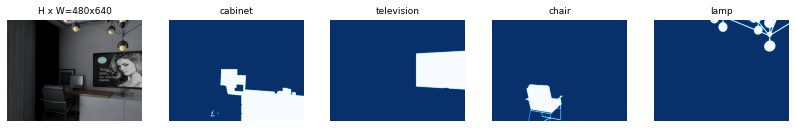

11891


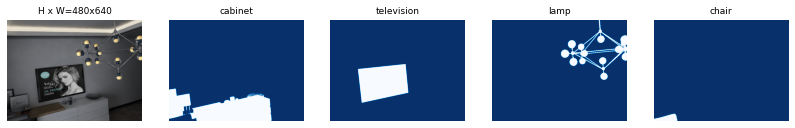

In [7]:
image_ids = dataset_train.load_view(2)
print(image_ids)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    print(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [26]:
class TrainConfig(interior_seq.InteriorNetConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 10
    NUM_CLASSES = len(selected_classes)  # background + num classes
    vmin = -1.
    vmax = 1.
    grid_dist = 2
    nvox = 100
    nvox_z = 100
    vsize = float(vmax - vmin) / nvox
    vox_bs = 1
    im_bs = 1
    samples = 50
    min_z = 1000
    max_z = 1000
    NUM_VIEWS = 2
    RECURRENT = False
    USE_RPN_ROIS = True
    DETECTION_MIN_CONFIDENCE = 0.0
    GRID_REAS = 'ident'
    
config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
GRID_REAS                      ident
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                36
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE      

In [27]:
import json
with open(os.path.join(ROOT_DIR,'data/InteriorNet/data/HD1/train/instance_mapping.json')) as json_file:
    instance_map = json.load(json_file)
#print(instance_map)

In [28]:
instance = np.random.choice(list(instance_map.keys()),1)[0]

obj_inst = np.asarray(instance_map[instance])
print(obj_inst.shape)
views = np.random.choice(range(obj_inst.shape[0]),2)
print(views)
image_ids = obj_inst[views][:,1]
print(image_ids)
#print(dataset_train.image_from_source_map)
print(dataset_train.load_view(2))

(253, 2)
[ 92 117]
['3FO4JXILITSO_id0000000017751666688' '3FO4JXILITSO_id0000000026151665664']
[13444, 13443]


In [43]:
# obj_inst = np.array(instance_map['17'])
# image_ids = obj_inst[0:config.NUM_VIEWS][:,1]
# # image_ids = [obj_inst[0][1], obj_inst[20][1]]
# image_ids = np.random.choice(dataset_train.image_ids, config.NUM_VIEWS*1)
image_ids = np.array(dataset_train.load_view(2))
# image_ids = np.array([300, 301])

image_pairs = image_ids.reshape([-1,config.NUM_VIEWS])
print(image_ids)
im = []
Rcam = []
print([config.NUM_VIEWS] + list(config.IMAGE_SHAPE))
# for image_id in image_ids:
#     image_id = dataset_train.image_from_source_map["interior.33FO4JXILITSO_id"+image_id]
#     image = dataset_train.load_image(image_id)
#     image, _, _, _, _ = utils.resize_image(image, min_dim=config.IMAGE_MIN_DIM, max_dim=config.IMAGE_MAX_DIM, mode="square")
#     im.append(image)
#     Rcam.append(dataset_train.load_R(image_id))
for image_pair in image_pairs:
    im = []
    Rcam = []
    Kmat = dataset_train.K
    for image_id in image_pair:
        image = dataset_train.load_image(image_id)
        image, _, _, _, _ = utils.resize_image(image, min_dim=config.IMAGE_MIN_DIM, max_dim=config.IMAGE_MAX_DIM, mode="square")
        im.append(image)
        Rcam.append(dataset_train.load_R(image_id))
    im = np.stack(im)
    Rcam = np.stack([Rcam])
    Kmat = np.stack([Kmat])
    print(im.shape)
    print(Rcam.shape)
    print(Kmat.shape)


# Free Memory
del image

from keras.backend.tensorflow_backend import set_session
config_tf = tf.ConfigProto()
config_tf.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config_tf.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config_tf)
set_session(sess)  # set this TensorFlow session as the default session for Keras
model = projection1.ProjectionNet(config)
im_res, grid = model.run([[im], Rcam, Kmat])
tf.reset_default_graph()
del model
del sess

[16507 16504]
[2, 640, 640, 3]
(2, 640, 640, 3)
(1, 2, 3, 4)
(1, 3, 3)
nR: 2
grid_range_z:  [100]
1.875
nV:  1000000
rs_grid:  [3, 1000000]
nR: 2
grid_range_z:  [100]
1.875
nV:  1000000
rs_grid:  [3, 1000000]
Grid_shape grid_reas: [1, 2, 100, 100, 100, 3]
Grid_shape grid_reas2: [1, 3, 100, 100, 100, 2]
Grid_shape grid_reas_end: [1, 100, 100, 100, 3]
Grid_shape grid_reas: [1, 2, 100, 100, 100, 3]
Grid_shape grid_reas2: [1, 3, 100, 100, 100, 2]
Grid_shape grid_reas_end: [1, 100, 100, 100, 3]


(640, 640, 3)


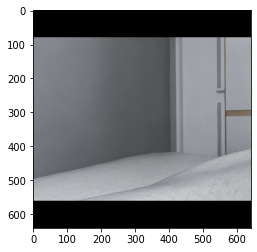

In [44]:
plt.imshow(im[1])
print(im[0].shape)
# cv2.imwrite(os.path.join(ROOT_DIR,'data/InteriorNet/Results/unproj/original.png'), im[1][:,:,::-1])

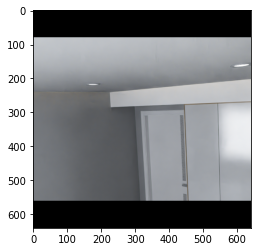

In [45]:
plt.imshow(im[0])

In [46]:
# print(grid.shape)
# unproj = grid[0,0,20,:,:,:]
# plt.imshow(unproj/255)
# cv2.imwrite(os.path.join(ROOT_DIR,'data/InteriorNet/Results/unproj/unproj.png'), unproj[:,:,::-1])

(1, 50, 100, 100, 3)


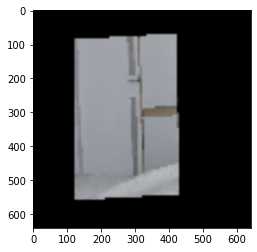

In [50]:
print(im_res.shape)
im_resized, _, _, _, _ = utils.resize_image(im_res[0,38,:,:,:]/255, min_dim=config.IMAGE_MIN_DIM, max_dim=config.IMAGE_MAX_DIM, mode="square")
plt.imshow(im_resized)

In [40]:
# cv2.imwrite(os.path.join(ROOT_DIR,'data/InteriorNet/Results/unproj/proj.png'), im_res[0,0,:,:,::-1])

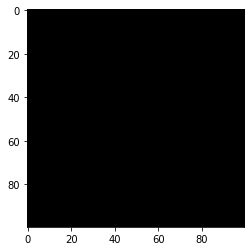

In [41]:
plt.imshow(grid[0,50,:,:,:]/255)